# **RAG Project: Ukraine-Russia War**
### **Authors**
**NICETTO ANDREA** (badge 2095329) from COMPUTER ENGINEERING curriculum BIOINFORMATICS \\
**RUSSO CHRISTIAN FRANCESCO** (badge 2087922) from COMPUTER ENGINEERING curriculum ARTIFICIAL INTELLIGENCE AND ROBOTICS

### **RAG schema**
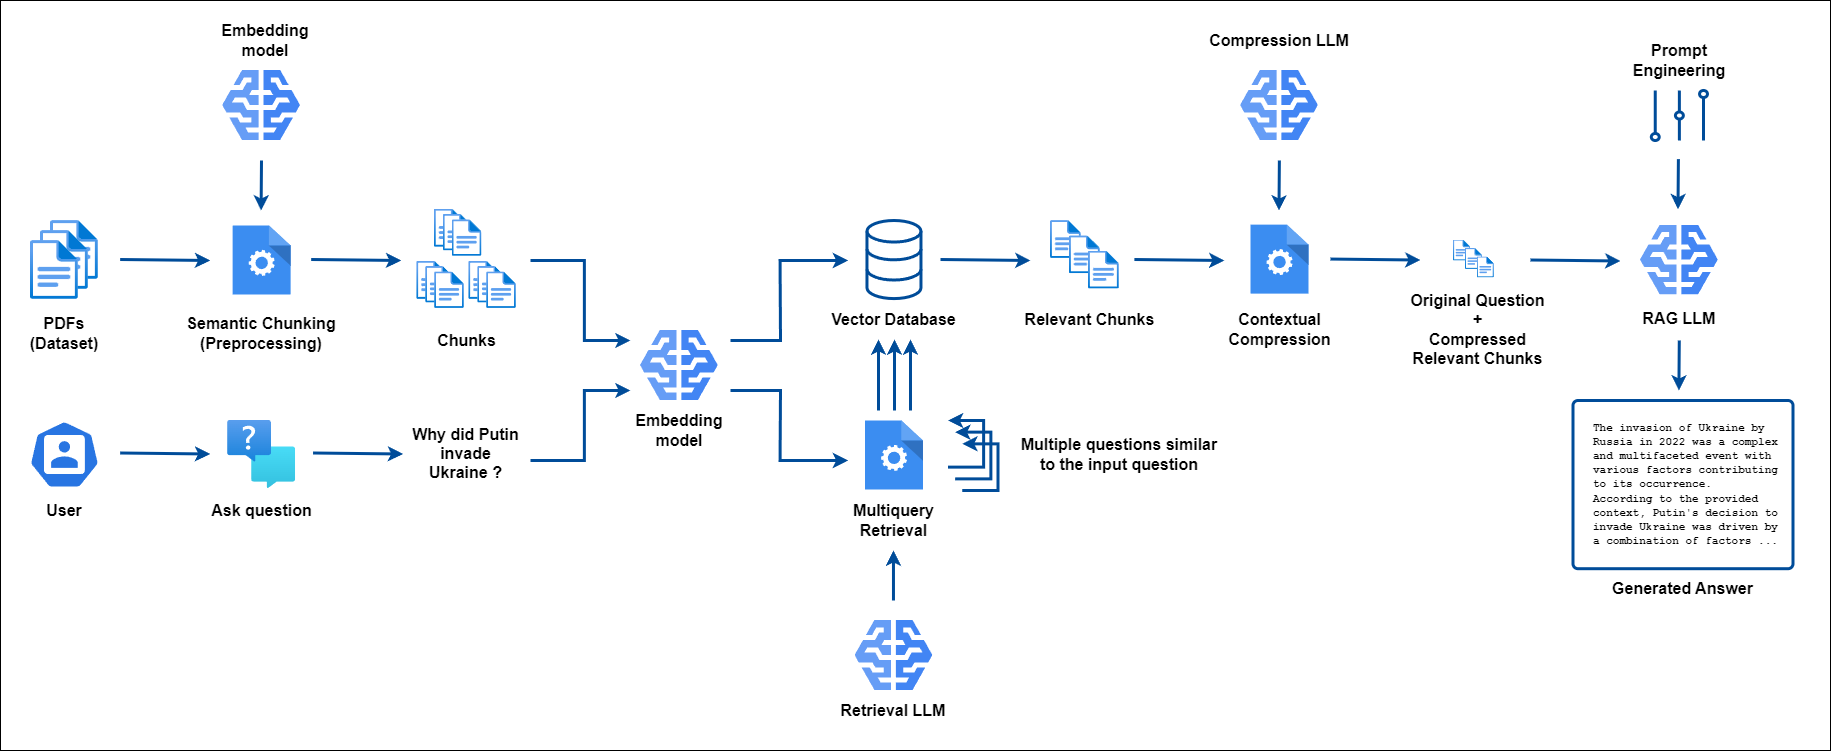

### **Project Overview**
**Goal:** the goal of this notebook is to build a **RAG (Retrieval Augmented Generation)** pipeline for the question-answering task based on some retrieved documents regarding the Ukraine-Russia war (2022-today).


**Schema:** the RAG pipeline schema is reported above.


**Main features and frameworks:**
*   **Document loading and reading:** the dataset is composed by a set of PDFs of different sizes with topic: "The Ukraine-Russia War (2022-today)".
*   **Text preprocessing:** `MyMuPDF` library.
*   **Text chunking:** `Semantic Chunking`.
*   **Text embedding:** `stsb-roberta-large` for general embedding, and `msmarco-distilbert-base-v2` for langchain embedding (for ChromaDB).
*   **Text Retrieval:** `Multiquery Retrieval`, `Contextual Compression`, both using the LLM `Gemma 2b it`.
*   **Prompt engineering**
*   **RAG:** using the LLM `LLama 3 8b it`.




> **Note:** in this notebook we test 2 different kinds of compressions:
*   **Light compression:** the one shown in the schema above, which is applied on the retrieved chunks in order to extract from them only the relevant information and to reduce their size.  
*   **Heavy compression:** consists in appling the compression directly on the original chunks, in this way the retrieval is done on the compressed chunks allowing to improve the search process based on the given query.

More details on each specific component of the RAG pipeline and on the compression will be provided later in the notebook.

**Dataset:**


* The dataset consists in 306 pages divided in 21 pdf files each one corresponding to a chapter of the book "War in Ukraine : conflict, strategy, and the return of a fractured world" by MUSE, which is a digital content provider for the humanities and social sciences and offers full-text versions of academic journals and books from various university presses and scholarly societies. The full reference is available here: [MUSE book](https://muse.jhu.edu/pub/1/oa_edited_volume/chapter/3881911) \

* Statistics regarding the dataset can be found in section 3 of the notebook called "*Text preprocessing*". This section examines the number of sentences, the number of chunks, and the number of characters within each document and in the dataset as a whole.







---


## **0. Install all the required modules**


---



In [ ]:
!pip install tqdm
!pip install PyMuPDF # see: https://github.com/pymupdf/PyMuPDF
!pip install spacy
!pip install -U sentence-transformers # see: https://www.sbert.net/docs/pretrained_models.html
!pip install -U transformers
!pip install bitsandbytes accelerate
!pip install langchain
!pip install -U langchain-community
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 6.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinu

---


## **1. Embedding models and LLMs loading**


---

In this section, we perform the following task:
* Defining the LLMs and embedding models which will be used later in the next sections of this notebook, where these models are imported from Hugging Face transformers.

**Model Definition and Loading:**
* To achieve effective Retrieval and Augmented-Generation (RAG), we decided to exploit two LLMs:
  * **Retrieval Model:** This model is responsible for handling the retrieval and the compression tasks.
  * **RAG Model:** This model handles the augmented generation task.

* Specifically:
  * **Retrieval Model:** For both multiquery retrieval and semantic compression we chose to use the same LLM: Gemma. Since its primary function is just to generate new queries based on the user's initial query and to compress a (not too long) text, a lighter model like Gemma can be sufficient.
  * **RAG Model:** For augmented generation, we chose to use the Llama 3 LLM. A more powerful model is recommended here, as it can produce better results, also considering biggest amounts of context (i.e., information), for the generation task.

> **Note:** you may choose to use the same model for all tasks or to select different models (e.g., for retrieval and for compression) based on your requirements.

**Embedding Models:**
* We decided to use two embedding models in this notebook:
  * **"stsb-roberta-large":** This model will be used for semantic segmentation.
  * **"msmarco-distilbert-base-v2":** This model will be used in Chroma for effective document retrieval.

**Local Loading Requirements:**
* To run the models locally, we need the following components:
  * **Quantization Config (optional):** A configuration for the precision in which the model should be loaded (e.g., 8-bit, 4-bit).
  * **Model ID:** An identifier to tell transformers which model/tokenizer to load.
  * **Tokenizer:** This component converts text into numbers ready for the LLM. Note that a tokenizer is distinct from an embedding model.
  * **LLM Model:** This is the model we use to generate text based on input.

* For improved performance, consider using techniques such as `flash_attn` (Flash Attention 2). More information can be found on the [Flash Attention GitHub](https://github.com/Dao-AILab/flash-attention).

**Hugging Face Access Tokens:**
* When using LLMs, it's essential to pass the Hugging Face access token. These tokens should be added in the secret section in Colab as 'access_token' and 'HF_TOKEN' and retrieved using the `userdata.get()` method.


### Check GPU availability

In [ ]:
import torch

# Check if CUDA is available:
if torch.cuda.is_available():
    print("CUDA is available.")

    # Get the number of available GPUs:
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")

    # Get information about each GPU:
    for i in range(torch.cuda.device_count()):
        gpu = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {gpu.name}, Compute Capability: {gpu.major}.{gpu.minor}")

    # Get the currently selected GPU:
    current_gpu = torch.cuda.current_device()
    print(f"Currently selected GPU number: {current_gpu}")
else:
    print("CUDA is not available.")

# Chech local GPU available memory
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

# Set the available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available.
Number of GPUs available: 1
GPU 0: Tesla T4, Compute Capability: 7.5
Currently selected GPU number: 0
Available GPU memory: 15 GB


### Util functions
Helper functions to get the number of parameters of the model and the memory occupied by it.

In [ ]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])



def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate model sizes
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

### Define the Embedding Model

**Tested models:**

We evaluated various embedding models for our project, each offering unique strengths:

* **"all-mpnet-base-v2"**: This model offers a larger architecture suitable for complex tasks requiring deep semantic understanding. It has 109M params and maps sentences & paragraphs to a 768 dimensional dense vector space.
  
* **"all-MiniLM-L6-v2"**: A smaller and faster variant within the MiniLM family, ideal for resource-constrained environments. It has 22.7M params and maps sentences & paragraphs to a 384 dimensional dense vector space.
  
* **"stsb-roberta-large"**: Fine-tuned on benchmarks such as the STS benchmark, this model excels in tasks related to semantic similarity and textual entailment. This model has 355M params and maps sentences & paragraphs to a 1024 dimensional dense vector space.
  
* **"msmarco-distilbert-base-v2"**: A distilled version trained on the MSMARCO dataset, optimized for information retrieval tasks. This model has 66.4M params and maps sentences & paragraphs to a 768 dimensional dense vector space.

**Selected models:**

Based on our evaluation, we selected:

* **"msmarco-distilbert-base-v2"** for its strength in information retrieval. We integrated the model with LangChain for our retrieval tasks.
* **"stsb-roberta-large"** for semantic chunking and similarity sorting, we found that the standalone capability of this model meets our needs effectively without requiring integration with LangChain.


In [ ]:
from sentence_transformers import SentenceTransformer

# Define a pretrained sentence embedding model (used for general embedding purposes)
#general_embedding_model_id = "all-mpnet-base-v2"
#general_embedding_model_id = "all-MiniLM-L6-v2"
general_embedding_model_id = "stsb-roberta-large"

general_embedding_model = SentenceTransformer(
    model_name_or_path=general_embedding_model_id,
    device=device
)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.96k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [ ]:
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings

# Define a pretrained sentence embedding model already wrapped to be integrated in langchain (used for ChromaDB)
#langchain_embedding_model_id = "all-MiniLM-L6-v2"
#langchain_embedding_model_id = "all-mpnet-base-v2"
langchain_embedding_model_id = "msmarco-distilbert-base-v2"

langchain_embedding_model = SentenceTransformerEmbeddings(model_name=langchain_embedding_model_id)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Define the Retrieval LLM
We decided to use an instruction-tuned large language model (LLM) for the retrieval task.  Instruction-tuned models are perfect for this because they are trained to give specific and relevant responses based on the prompts.

Regarding the retrieval task, it is possible to use a lighter LLM since its primary functions are just to generate multiple queries from the initial one and to summarize some text. These tasks do not require extensive contextual understanding or high computational performance. For this reason we opted for the model "Gemma-2b-it", take a look [here](https://huggingface.co/google/gemma-2b-it) for more informations.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available
from transformers import BitsAndBytesConfig
from google.colab import userdata

use_quantization_config = True

# Create a quantization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

# Bonus: flash attention 2 = faster attention mechanism
# Flash Attention 2 requires a GPU with a compute capability score of 8.0+ (Ampere, Ada Lovelace, Hopper and above): https://developer.nvidia.com/cuda-gpus
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa" # scaled dot product attention
print(f"Using attention implementation: {attn_implementation}")

# Pick a model we'd like to use
retreival_model_id = "google/gemma-2b-it"
#retreival_model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

# Instantiate tokenizer (tokenizer turns text into tokens)
retrieval_tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path=retreival_model_id,
    token=userdata.get('access_token')
)

# Instantiate the model
retrieval_llm = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=retreival_model_id,
    torch_dtype=torch.float16,
    quantization_config=quantization_config if use_quantization_config else None,
    low_cpu_mem_usage=True,
    attn_implementation=attn_implementation,
    token=userdata.get('access_token')
)

if not use_quantization_config:
    retrieval_llm.to("cuda")

Using attention implementation: sdpa


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
get_model_num_params(retrieval_llm)

1515268096

In [ ]:
get_model_mem_size(retrieval_llm)

{'model_mem_bytes': 2039641088, 'model_mem_mb': 1945.15, 'model_mem_gb': 1.9}

### Define the RAG LLM

We utilized an instruction-tuned large language model (LLM), as for the RAG model, to effectively perform prompting. This choice was made because instruction-tuned models are specifically trained for prompting tasks, ensuring they can generate relevant and accurate answers based on provided instructions. In contrast, chat models are not ideal for this purpose as they are primarily designed for conversational interactions and lack the specialized training required for effective prompting.
> **Note:** As first approach we used Gemma also for the RAG task. Then we sought for a more powerful LLM, in particular, we experimented with other models such as LLaMA 2 and LLaMA 3, and decided to keep LLaMA 3 because it provided better results based on our evaluations.

See [here](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct) for more informations about Llama 3 model.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available
from transformers import BitsAndBytesConfig
from google.colab import userdata

# Create a quantization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

# Bonus: flash attention 2 = faster attention mechanism
# Flash Attention 2 requires a GPU with a compute capability score of 8.0+ (Ampere, Ada Lovelace, Hopper and above): https://developer.nvidia.com/cuda-gpus
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa" # scaled dot product attention
print(f"Using attention implementation: {attn_implementation}")

# Pick a model we'd like to use
rag_model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

# Instantiate tokenizer (tokenizer turns text into tokens)
rag_tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path=rag_model_id,
    token=userdata.get('access_token')
)

# Instantiate the model
rag_llm = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=rag_model_id,
    torch_dtype=torch.float16,
    quantization_config=quantization_config if use_quantization_config else None,
    low_cpu_mem_usage=True,
    attn_implementation=attn_implementation,
    token=userdata.get('access_token')
)

if not use_quantization_config:
    rag_llm.to("cuda")

Using attention implementation: sdpa


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [ ]:
get_model_num_params(rag_llm)

4540600320

In [ ]:
get_model_mem_size(rag_llm)

{'model_mem_bytes': 5591547904, 'model_mem_mb': 5332.52, 'model_mem_gb': 5.21}



---


## **2. Document loading and reading**


---




In this section we perform the following tasks:
*   Downloading the PDF documents.
*   Loading the PDF documents.
*   Reading and extracting the text from each page of each PDF document, along with some metadata (document name, page number, number of sentences, words, tokens, etc.).
*   Preprocessing and cleaning the text of each page (to remove the headers, footnotes, special characters, etc.).



### Load the PDF documents

In [ ]:
import os
import requests

def document_downloader(pdf_path: str, pdf_url: str) -> None:
    """
        Downloads the PDF document in the provided pdf_path from the provided
        pdf_url if the document had not yet been downloaded.
    """

    # Download PDF
    if not os.path.exists(pdf_path):
        print("[INFO] File \'{pdf_path}\' doesn't exist, downloading...")

        # The local filename to save the downloaded file
        filename = pdf_path

        # Send a GET request to the URL
        response = requests.get(pdf_url)

        # Check if the request was successful
        if response.status_code == 200:
            # Open the file and save it
            with open(filename, "wb") as file:
                file.write(response.content)

            print(f"[INFO] The file has been download and saved as {filename}")
        else:
            print(f"[INFO] Failed to download the file. Status code: {reponse.status_code}")

    else:
        print(f"[INFO] File \'{pdf_path}\' already exists.")

In [ ]:
# Define the list of chapters for the book downloadable from Project Muse
muse_book_chapters = []

for i in range(12, 33):
    muse_book_chapters.append(dict(
        path = "War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter " + str(i-12) + ".pdf",
        url = "https://muse.jhu.edu/pub/1/oa_edited_volume/chapter/38819" + str(i) + "/pdf",
        from_page = 1,
        to_page =-1
    ))

# Define the dataset of PDF documents
pdf_dataset = []
pdf_dataset.extend(muse_book_chapters)

In [ ]:
from tqdm.auto import tqdm

# Download the PDF documents
for pdf in tqdm(pdf_dataset, desc="Downloading PDFs"):
    document_downloader(pdf_path=pdf["path"], pdf_url=pdf["url"])

[INFO] File '{pdf_path}' doesn't exist, downloading...
[INFO] The file has been download and saved as War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 0.pdf
[INFO] File '{pdf_path}' doesn't exist, downloading...
[INFO] The file has been download and saved as War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 1.pdf
[INFO] File '{pdf_path}' doesn't exist, downloading...
[INFO] The file has been download and saved as War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 2.pdf
[INFO] File '{pdf_path}' doesn't exist, downloading...
[INFO] The file has been download and saved as War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 3.pdf
[INFO] File '{pdf_path}' doesn't exist, downloading...
[INFO] The file has been download and saved as War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 4.pdf
[INFO] File '{pdf_path}' doesn't exist, downloadin

### Open and read pages from the PDF documents



In [ ]:
import fitz
from tqdm.auto import tqdm
import re

def text_formatter(text: str) -> str:
    """
        Cleans and formats a given text by removing specific patterns such as
        headers, side patterns, and Unicode escape sequences, and performs
        general text cleanup.
    """

    # Remove the headers of the document
    header_pattern_1 = r'^[\d]+\s*[\u2003\s]*[\w\s]+\n'
    header_pattern_2 = r'^[\w\s]+[\u2003\s]*[\d]+\n'
    header_pattern_3 = r'^[\w\s,\xad]+\u2003\s*\d+\n'
    header_pattern_4 = r'^Amer\xad\ni\xad\nca’s Global Role in the Shadow of the Ukraine Conflict\u2003 \u2003 \d+\n'
    header_pattern_5 = r'^.*?[\xad\s\u2003][^\d\n]*\d+\n'

    text = re.sub(header_pattern_1, '', text)
    text = re.sub(header_pattern_2, '', text)
    text = re.sub(header_pattern_3, '', text)
    text = re.sub(header_pattern_4, '', text)
    text = re.sub(header_pattern_5, '', text)

    # Remove the side patterns of the document
    pattern = r'\n(?:\[\d+\.\d+\.\d+\.\d+\]\s+)?Project\s+MUSE\s+\(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}\s+GMT\)\n'
    text = re.sub(pattern, '', text)

    pattern = r'^\d+\s*[\u2003\s]*\S+\s+\S+\.'
    text = re.sub(pattern, '', text, flags=re.MULTILINE)

    # Remove all Unicode escape sequences of the form \u<something>
    text = re.sub(r'\\u[\da-fA-F]{4}', '', text)

    # Clean up the text
    cleaned_text = text \
        .replace("\xad\n", "") \
        .replace("\xad", "") \
        .replace("\u00ad", "") \
        .replace("\2008", "") \
        .replace("\u200b", "") \
        .replace("\xa02", "") \
        .replace("\xa0", "") \
        .replace("\N{SOFT HYPHEN}", "") \
        .replace("-\n", "") \
        .replace("\n", " ") \
        .replace("  ", " ") \
        .strip()

    # ...Potentially more text formatting functions can go here...

    return cleaned_text



def document_pages_reader(pdf_path: str, from_page: int=0, to_page: int=-1) -> list[dict]:
    """
        Opens, reads and extracts metadata from each page of the provided PDF
        document.
    """

    # Open the PDF document
    doc = fitz.open(pdf_path)

    pages_metadata = []

    # Read and extract data for each page of the PDF document
    for page_number, page in enumerate(doc):
        if (page_number > from_page) and (to_page == -1 or page_number < to_page):
            # Extract page text
            text = page.get_text()

            # Consider the text up to the final notes
            start_index = text.find("notes")

            if start_index != -1:
                text = text[:start_index]

            # Format page text
            text = text_formatter(text=text)

            # Store metadata information for the current page
            pages_metadata.append({
                "document_name": pdf_path,
                "page_number": page_number - 0,
                #"page_sentence_raw_count": len(text.split(". ")),
                "page_word_count": len(text.split(" ")),
                "page_token_count": len(text) / 4, # 1 token = ~4 characters
                "page_char_count": len(text),
                "text": text
            })

            # Remove final notes from text
            if start_index != -1:
                break

    # Close the PDF document
    doc.close()

    return pages_metadata

In [ ]:
pages_metadata = []

# Read PDF documents pages and extract metadata
for pdf in tqdm(pdf_dataset, desc="Reading PDFs"):
    pages_metadata.extend(document_pages_reader(pdf_path=pdf["path"]))

Reading PDFs:   0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
import random

random.sample(pages_metadata, k=1)

[{'document_name': 'War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 5.pdf',
  'page_number': 2,
  'page_word_count': 425,
  'page_token_count': 669.0,
  'page_char_count': 2676,
  'text': 'reveals an acute policy failure (or series of failures) for the United States. After World War II, the United States became the security guarantor for Western Europe. Despite never-ending Cold War drama and intrigue—and Soviet invasions of Eastern Europe in 1956 and 1968—there was no war in Europe between  For forty-four years, the US maintained a brilliant record of deterrence. After the collapse of the Soviet Union in 1991, the idea of Europe expanded to include the Balkans as well as Central and Eastern Europe, two very imprecise terms of art. A Europe “whole, free, and at peace” grew into the aspirational core of US policy toward a region that encompassed the original NATO countries and the former Soviet Union. Technically a security guarantor only for NATO, the 

In [ ]:
import pandas as pd

df = pd.DataFrame(pages_metadata)
df.head()

,document_name,page_number,page_word_count,page_token_count,page_char_count,text
0,"War in Ukraine: Conflict, Strategy, and the Re...",1,241,399.00,1596,W e don’t yet know how the war in Ukraine will...
1,"War in Ukraine: Conflict, Strategy, and the Re...",2,430,672.75,2691,International Studies timed to coincide with t...
2,"War in Ukraine: Conflict, Strategy, and the Re...",3,442,696.25,2785,struggles involving the remnants of the Soviet...
3,"War in Ukraine: Conflict, Strategy, and the Re...",4,421,674.75,2699,"Second, this war was the result of a double fa..."
4,"War in Ukraine: Conflict, Strategy, and the Re...",5,412,659.25,2637,thought he could perpetrate such a heinous cri...


In [ ]:
df.drop(columns=['page_number']).describe().round(2)

,page_word_count,page_token_count,page_char_count
count,265.00,265.00,265.00
mean,391.44,629.90,2519.61
std,98.85,158.21,632.86
min,1.00,0.00,0.00
25%,399.00,648.50,2594.00
50%,424.00,686.25,2745.00
75%,443.00,703.75,2815.00
max,479.00,747.75,2991.00




---


## **3. Text preprocessing**


---



In this section we perform the following tasks:
*   Splitting the text of each page into sentences.
*   Chunking to group sentences into chunks of text.
*   Filtering short chunks of text.

**Chunking:**
*   There mainly exist 5 chunking methods:

    *   Fixed size chunking
    *   Recursive Chunking
    *   Document Specific Chunking
    *   Semantic Chunking
    *   Agentic Chunking
    
*   The approach that we adopt in this notebook is the `Semantic Chunking`.

*   **Semantic chunking** involves taking the embeddings of every sentence in the document, comparing the similarity of all adjacent sentences with each other, and then grouping sentences with the most similar embeddings together.

*   The embedding of each sentence is generated using the `general_embedding_model` defined at section "*1. Embedding models and LLMs loading*".

> **Note:** we also tested Fixed size Chunking, Recursive Chunking, and Document Specific Chunking, which are more naive approaches than Semantic Chunking.
However, as expected, the latter turned out to perform better.

> **Note:** we also started implementing the Agentic Chunking, which is a more complex method involving the use of a LLM (agent) to iteratively decide whether coupling two sentences together to build the chunks of text. Even if more powerful, this approach is computationally expensive, for this reason we have discarded it.

**Token count:**
*   In the code below we keep track of the token count in each page, sentence, chunk, filtered chunk.

*   Why would we care about token count?\
    Token count is important to think about because:
    1. Embedding models don't deal with infinite tokens.
    2. LLMs don't deal with infinite tokens.

*   In particular, it is important to take into account that each model has a context window of a maximum fixed size of tokens it can take in input.
*   Our goal in RAG is to pass our LLM as much context (i.e., information) as possible. To do so, we need to generate chunks that:
    *   Are not too big, nor too small, of adaptive size.
    *   Maintain the semantic integrity of the text, ensuring each chunk is contextually rich and meaningful.
    *  Allow to gather together meaningful and contextually complete information to improve the efficiency of our system.











### Split pages into sentences

Here we split each page into sentences.

> Note: sentences are not necessarily separated by a period (e.g. "Mr. Green." is just one sentence). For this reason we use the Spycy library to handle these cases.

> Note: we decided to not consider the question mark as a separator, this to keep question and first sentence of the answer together in the same sentence, in order to increase the probability to chunk together the question with its full answer.

In [ ]:
from spacy.lang.en import English

def pages_sentencizer(pages_metadata: list[dict]) -> None:
    """
        Splits the text of each page into sentences.
    """

    # Add a sentencizer pipeline, see https://spacy.io/api/sentencizer
    text_processor = English()
    sentencizer = text_processor.add_pipe("sentencizer")

    # Remove '?' from the list of punctuation characters that trigger sentence boundary detection
    if "?" in sentencizer.punct_chars:
        sentencizer.punct_chars.remove("?")

    # Split the text of each page into sentences
    for item in tqdm(pages_metadata, "Splitting pages"):
        # Split the text of the current page into sentences and store them in 'pages_metadata'
        item["sentences"] = list(text_processor(item["text"]).sents)

        # Make sure all sentences are strings (the default type is a spaCy datatype)
        item["sentences"] = [str(sentence) for sentence in item["sentences"]]

        # Count the sentences and store the count in 'pages_metadata'
        item["page_sentence_count"] = len(item["sentences"])

In [ ]:
# Split pages into sentences
pages_sentencizer(pages_metadata)

Splitting pages:   0%|          | 0/265 [00:00<?, ?it/s]

In [ ]:
random.sample(pages_metadata, k=1)

[{'document_name': 'War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 2.pdf',
  'page_number': 16,
  'page_word_count': 454,
  'page_token_count': 703.75,
  'page_char_count': 2815,
  'text': 'an American-led defense treaty and nuclear umbrella. In some ways, everything in the world, no matter how tragic from a humanitarian perspective, no matter how important from a strategic perspective, falls short of the question of managing risks with China. Avoiding either a global war or capitulation in East Asia must be the top US strategic priority. In this light, too, an indefinite attritional war in Ukraine appears to defy strategic logic no less than capitulation there. True, some analysts argue that credibility is indivisible, so a US failure in Ukraine would reverberate globally, emboldening adversaries. But this latest version of a domino theory does not stand up to the historical record, certainly with regard to the aftermath of Vietnam. The regime in Bei

In [ ]:
df = pd.DataFrame(pages_metadata)
df.drop(columns=['page_number']).describe().round(2)

,page_word_count,page_token_count,page_char_count,page_sentence_count
count,265.00,265.00,265.00,265.00
mean,391.44,629.90,2519.61,15.04
std,98.85,158.21,632.86,5.28
min,1.00,0.00,0.00,0.00
25%,399.00,648.50,2594.00,12.00
50%,424.00,686.25,2745.00,15.00
75%,443.00,703.75,2815.00,18.00
max,479.00,747.75,2991.00,28.00


In [ ]:
def sentences_extractor(pages_metadata: list[dict]) -> list[dict]:
    """
        Splits each sentence in its own item.
    """

    sentences_metadata = []

    # Split each sentence into its own item
    for item in tqdm(pages_metadata, "Processed sentences"):
        for sentence in item["sentences"]:
            # Store metadata for the current sentence in 'sentences_metadata'
            sentence_dict = {}
            sentence_dict["document_name"] = item["document_name"]
            sentence_dict["page_number"] = item["page_number"]
            sentence_dict["sentence"] = sentence

            # Get some statistics on our sentence and store them in 'sentences_metadata'
            sentence_dict["sentence_word_count"] = len([word for word in sentence.split(" ")])
            sentence_dict["sentence_token_count"] = len(sentence) / 4 # 1 token = ~4 chars
            sentence_dict["sentence_char_count"] = len(sentence)

            # Store metadata information for the current sentence
            sentences_metadata.append(sentence_dict)

    return sentences_metadata

In [ ]:
sentences_metadata = sentences_extractor(pages_metadata)

Processed sentences:   0%|          | 0/265 [00:00<?, ?it/s]

In [ ]:
random.sample(sentences_metadata, k=1)

[{'document_name': 'War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 3.pdf',
  'page_number': 14,
  'sentence': 'They will realize that life in a big common state, which they do not love much now, is better than death.',
  'sentence_word_count': 21,
  'sentence_token_count': 26.25,
  'sentence_char_count': 105}]

In [ ]:
df = pd.DataFrame(sentences_metadata)
df.drop(columns=['page_number']).describe().round(2)

,sentence_word_count,sentence_token_count,sentence_char_count
count,3986.00,3986.00,3986.00
mean,26.07,41.66,166.62
std,16.81,27.68,110.73
min,1.00,0.50,2.00
25%,15.00,23.75,95.00
50%,23.00,36.50,146.00
75%,33.00,52.75,211.00
max,165.00,295.50,1182.00


### Chunking: group sentences into chunks of text

Here we combine each sentence with the sentence before and the sentence after, so that we reduce the noise and capture more of the relationship between sequential sequences. The `buffer_size` parameter is configurable, hence, it is possible to select how big of a window (of sentences) we want.

In [ ]:
def sentences_combiner(sentences_metadata: list[dict], buffer_size: int=1) -> None:
    """
        Combines sentences within each page considering sentences before and
        sentences after, based on a specified buffer size, and including the
        current sentence.
    """

    # Combine sentences together
    for i, item in tqdm(enumerate(sentences_metadata), "Processed sentences", total=len(sentences_metadata)):
        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences_metadata[j]["sentence"] + " "

            # Add the current sentence
            combined_sentence += sentences_metadata[i]["sentence"]

            # Add sentences after the current one, based on the buffer size
            for j in range(i + 1, i + 1 + buffer_size):
                # Check if the index j is within the range of the sentences list
                    if j < len(sentences_metadata):
                        # Add the sentence at index j to the combined_sentence string
                        combined_sentence += " " + sentences_metadata[j]["sentence"]

            # Store the combined sentence in 'pages_metadata'
            sentences_metadata[i]["combined_sentences"] = combined_sentence

            # Get some statistics on our sentence and store them in 'sentences_metadata'
            sentences_metadata[i]["combined_sentences_word_count"] = len([word for word in combined_sentence.split(" ")])
            sentences_metadata[i]["combined_sentences_token_count"] = len(combined_sentence) / 4 # 1 token = ~4 chars
            sentences_metadata[i]["combined_sentences_char_count"] = len(combined_sentence)

In [ ]:
# Combine sentences within each page in groups of (2 * buffer_size sentences + 1) (with overlapping)
sentences_combiner(sentences_metadata, buffer_size=1)

Processed sentences:   0%|          | 0/3986 [00:00<?, ?it/s]

In [ ]:
random.sample(sentences_metadata, k=1)

[{'document_name': 'War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 10.pdf',
  'page_number': 12,
  'sentence': 'Almost immediately, key assumptions that undergirded the team’s work failed, and we were off script.',
  'sentence_word_count': 15,
  'sentence_token_count': 25.0,
  'sentence_char_count': 100,
  'combined_sentences': 'In a narrower sense, however, more than two months of planning bought the administration less than a week of predetermined policy implementation. Almost immediately, key assumptions that undergirded the team’s work failed, and we were off script. Still, those days were essential.37 Rather than building the play in real time, key enablers were already in place, allies and partners were on board, and agency leadership could focus on making adjustments where required.',
  'combined_sentences_word_count': 72,
  'combined_sentences_token_count': 117.25,
  'combined_sentences_char_count': 469}]

In [ ]:
df = pd.DataFrame(sentences_metadata)
df[["combined_sentences_word_count", "combined_sentences_token_count", "combined_sentences_char_count"]].describe().round(2)

,combined_sentences_word_count,combined_sentences_token_count,combined_sentences_char_count
count,3986.00,3986.00,3986.00
mean,78.20,125.46,501.84
std,31.82,53.11,212.45
min,3.00,2.00,8.00
25%,57.00,89.50,358.00
50%,74.00,117.50,470.00
75%,93.00,150.00,600.00
max,303.00,552.00,2208.00


Here we get the embedding for the combined sentences created before. Remember that **the embedding captures the semantic of each sentence**. In this way, we can get the distance between group of sentences in order to find the better breakpoints to split our text (i.e., to group sentences with similar meaning together into chunks).

In [ ]:
def combined_sentences_embedding(sentences_metadata: list[dict], embedding_model) -> None:
    """
        Encodes combined sentences from the input metadata using a provided
        embedding model and stores the resulting embeddings in the metadata.
    """

    # Encode combined sentences and store them in 'pages_metadata'
    for item in tqdm(sentences_metadata, desc="Processed sentence"):
        item['combined_sentence_embedding'] = embedding_model.encode(
            item['combined_sentences'],
            batch_size=32,
            convert_to_tensor=False
        )

In [ ]:
# Encode the combined sentences to get their vectorial representation
combined_sentences_embedding(sentences_metadata, general_embedding_model)

Processed sentence:   0%|          | 0/3986 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(sentences_metadata)
df.head()

,document_name,page_number,sentence,sentence_word_count,sentence_token_count,sentence_char_count,combined_sentences,combined_sentences_word_count,combined_sentences_token_count,combined_sentences_char_count,combined_sentence_embedding
0,"War in Ukraine: Conflict, Strategy, and the Re...",1,W e don’t yet know how the war in Ukraine will...,12,12.75,51,W e don’t yet know how the war in Ukraine will...,23,27.25,109,"[-0.033291616, -0.33160764, 0.011163133, 1.443..."
1,"War in Ukraine: Conflict, Strategy, and the Re...",1,"We do know, already, that this war has changed...",11,14.25,57,W e don’t yet know how the war in Ukraine will...,55,84.00,336,"[0.8748254, 0.19756399, 0.7215462, 1.5773898, ..."
2,"War in Ukraine: Conflict, Strategy, and the Re...",1,When Vladimir Putin sent his armies streaming ...,32,56.50,226,"We do know, already, that this war has changed...",54,88.50,354,"[0.30127254, 0.56336397, 0.74889255, 1.5109129..."
3,"War in Ukraine: Conflict, Strategy, and the Re...",1,He also accelerated the emergence of a more fr...,11,17.25,69,When Vladimir Putin sent his armies streaming ...,57,102.00,408,"[0.59386927, 1.4007093, 0.6486007, 1.5718353, ..."
4,"War in Ukraine: Conflict, Strategy, and the Re...",1,Putin’s assault intensified the great-power st...,14,27.75,111,He also accelerated the emergence of a more fr...,39,70.75,283,"[0.61983234, 2.0808153, 0.910724, 0.26954383, ..."


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences: list[dict]) -> tuple[list[float], list[dict]]:
    """
        Calculate the cosine distance between adjacent combined sentences
        embeddings.
    """

    distances = []

    # Calculate the cosine distance between adjacent combined sentences embeddings
    for i in range(len(sentences) - 1):
        curr_embedding = sentences[i]['combined_sentence_embedding']
        next_embedding = sentences[i + 1]['combined_sentence_embedding']

        # Calculate cosine similarity
        similarity = cosine_similarity([curr_embedding], [next_embedding])[0][0]

        # Convert to cosine distance
        distance = 1 - similarity

        # Append the cosine distance to the list
        distances.append(distance)

        # Store the distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentence[-1]['distance_to_next'] = None

    return distances, sentences

In [ ]:
# Calculate the cosine distance between adjacent combined sentences embeddings
distances, sentences = calculate_cosine_distances(sentences_metadata)

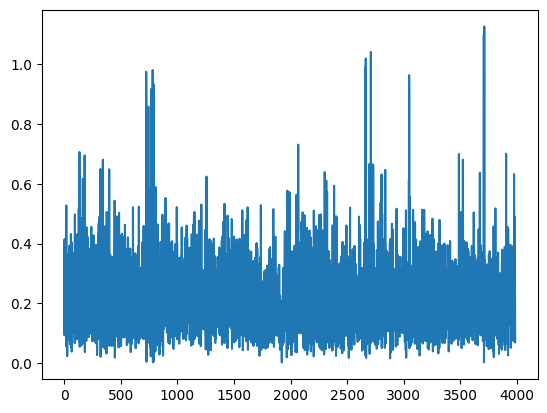

In [ ]:
import matplotlib.pyplot as plt

plt.plot(distances)

Here we define some helper functions to plot the semantic segmentation process.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_semantic_chunking(distances: list[int],
                           breakpoint_distance_threshold: int,
                           num_distances_above_threshold: int,
                           indices_above_threshold: list[int]) -> None:
    """
        Plots the semantic chunking of text based on distances between sentence
        embeddings.
    """

    # Plot the distances
    plt.plot(distances)

    # Set y-axis upper bound and plot limits
    y_upper_bound = 1.1 * max(distances)
    plt.ylim(0, y_upper_bound)
    plt.xlim(0, len(distances))

    # Plot the threshold line
    plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');
    plt.text(x=(len(distances)*0.01), y=y_upper_bound/50, s=f"{num_distances_above_threshold + 1} Chunks");

    # Define colors for shading
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Shade regions between breakpoints
    for i, breakpoint_index in enumerate(indices_above_threshold):
        start_index = 0 if i == 0 else indices_above_threshold[i - 1]
        end_index = breakpoint_index if i < len(indices_above_threshold) - 1 else len(distances)

        plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
        plt.text(
            x=np.average([start_index, end_index]),
            y=breakpoint_distance_threshold + (y_upper_bound)/20,
            s=f"Chunk #{i}",
            horizontalalignment='center',
            rotation='vertical'
        )

    # Shade the last region if necessary
    if indices_above_threshold:
        last_breakpoint = indices_above_threshold[-1]

        if last_breakpoint < len(distances):
            plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_threshold) % len(colors)], alpha=0.25)
            plt.text(
                x=np.average([last_breakpoint, len(distances)]),
                y=breakpoint_distance_threshold + (y_upper_bound)/20,
                s=f"Chunk #{i+1}",
                horizontalalignment='center',
                rotation='vertical'
            )

    # Set plot titles and labels
    plt.title("Text chunks based on embedding breakpoints")
    plt.xlabel("Index of sentences in the text (Sentence Position)")
    plt.ylabel("Cosine distance between sequential sentences")

    # Display the plot
    plt.show()



def plot_chunk_size_histogram(chunks_metadata: list[dict]) -> None:
    """
        Plots a histogram of chunk sizes from the given metadata.
    """

    # Extract chunk_word_counts
    chunk_word_counts = [chunk["chunk_word_count"] for chunk in chunks_metadata]

    # Create a bar plot to show the value of each chunk size
    plt.bar(range(len(chunk_word_counts)), chunk_word_counts)

    # Set the y-axis to log scale
    plt.yscale("log")

    # Set the x-axis limits
    plt.xticks(range(len(chunk_word_counts)), range(len(chunk_word_counts)))

    # Set the y-axis labels to show the actual chunk sizes
    plt.yticks(chunk_word_counts)

    # Set plot titles and labels
    plt.xlabel("Chunk Index")
    plt.ylabel("Chunk Size")
    plt.title("Chunks words count")
    plt.grid(True)

    # Display the plot
    plt.show()

Here we define the semantic segmentation function `sentences_semantic_chunking` which groups sentences with similar meaning (based on the distance between their embedding) to get our chunks. Additionally, some other helper functions are defined.

In [ ]:
from collections import defaultdict

def group_by_document(sentences_metadata: list[dict]) -> dict[list[dict]]:
    """
        Groups sentences based on their document name, taking advantage of
        adjacent storage.
    """

    # Initialize a defaultdict to store grouped sentences
    grouped_sentences = defaultdict(list)

    # Variable to keep track of the current document
    current_document = None

    # Iterate over each sentence's metadata
    for sentence_data in sentences_metadata:
        document_name = sentence_data['document_name']

        # Check if the document has changed
        if current_document != document_name:
            current_document = document_name

        # Append the sentence data to the corresponding document group
        grouped_sentences[current_document].append(sentence_data)

    return grouped_sentences



def build_chunk_metadata(group: list[dict], combined_text: str) -> dict:
    """
        Builds a dictionary containing the chunk metadata.
    """

    # Extract the sources of this chunk
    sources = []

    for item in group:
        source = {
            "document_name": item["document_name"],
            "page_number": item["page_number"]
        }

        # Check if source is already present in the set (avoids duplicates)
        if source not in sources:
            sources.append(source)

    # Store metadata for the chunk in 'chunks_metadata'
    chunk_dict = {}
    chunk_dict["sentences_sources"] = sources
    chunk_dict["chunk"] = combined_text

    # Get some statistics on our chunks and store them in 'chunks_metadata'
    chunk_dict["chunk_word_count"] = len([word for word in combined_text.split(" ")])
    chunk_dict["chunk_token_count"] = len(combined_text) / 4 # 1 token = ~4 chars
    chunk_dict["chunk_char_count"] = len(combined_text)

    return chunk_dict



def split_group_by_max_tokens(group, max_tokens_per_chunk):
    """
        Splits the group of sentences (a.k.a. chunk) into smaller groups,
        ensuring each chunk does not exceed max_tokens_per_chunk.
    """

    # Initialize variables to store the current chunk and its token count
    current_chunk = []
    current_token_count = 0
    chunks = []

    # Iterate over each sentence in the group
    for sentence in group:
        sentence_token_count = sentence["sentence_token_count"]

         # Check if adding the current sentence would exceed the maximum token count
        if current_token_count + sentence_token_count > max_tokens_per_chunk:
            # If so, append the current chunk to chunks and start a new chunk
            chunks.append(current_chunk)
            current_chunk = []
            current_token_count = 0

        # Add the current sentence to the current chunk
        current_chunk.append(sentence)
        current_token_count += sentence_token_count

    # Append the last chunk if it contains any sentences
    if current_chunk:
        chunks.append(current_chunk)

    return chunks

In [ ]:
def sentences_semantic_chunking(sentences_metadata: list[dict],
                                percentile_threshold: int = 95,
                                max_tokens_per_chunk: int = -1,
                                show_plot: bool=False) -> list[dict]:
    """
        Semantically groups sentences together into chunks, based on a
        percentile threshold which is related to the cosine distance between the
        embeddings of adjacents combined sentences.

        Ensures chunks do not exceed the max_tokens_per_chunk limit.
    """

    # Group sentences by PDF document
    grouped_sentences = group_by_document(sentences_metadata)

    # Create a list to hold the grouped sentences metadata
    chunks_metadata = []

    # Each PDF document is chunked independently
    for document_name, document_sentences_metadata in grouped_sentences.items():
        ## Find document sentences breakpoints
        # Calculate the cosine distance between adjacent combined sentences embeddings
        distances, sentences = calculate_cosine_distances(document_sentences_metadata)

        # Avoid errors for empty documents or for documents with just 1 sentence
        if len(distances) < 1:
            continue

        # Get the distance threshold that we'll consider an outlier exploiting numpy .percentile()
        breakpoint_percentile_threshold = percentile_threshold
        breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold)

        # Extract the distances which are above distance threshold
        num_distances_above_threshold = len([x for x in distances if x > breakpoint_distance_threshold])

        # Get the indices of the distances that are above the threshold. This will tell us where we should split the sentences
        indices_above_threshold = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold]

        ## Plot document semantic chunking
        print(f"Document name: {document_name}")

        # Plot the semantic chunking
        if show_plot:
            plot_semantic_chunking(distances, breakpoint_distance_threshold, num_distances_above_threshold, indices_above_threshold)

        print("\n")

        ## Document chunking and chunks metadata storage
        # Initialize the start index
        start_index = 0

        # Iterate through the breakpoints to slice the sentences
        for index in indices_above_threshold:
            # The end index is one less than the current breakpoint
            end_index = index - 1

            # Slice the sentence_dicts from the current start index to the end index
            group = sentences[start_index:end_index + 1]

            # Further split the group if it exceeds the max tokens per chunk
            if max_tokens_per_chunk > 0:
                group_chunks = split_group_by_max_tokens(group, max_tokens_per_chunk)
            else:
                group_chunks = [group]

            for chunk in group_chunks:
                combined_text = " ".join([d["sentence"] for d in chunk])

                # Build chunk metadata
                chunk_dict = build_chunk_metadata(chunk, combined_text)

                # Store metadata information for the current chunk
                chunks_metadata.append(chunk_dict)

            # Update the start index for the next group
            start_index = index

        # The last group, if any sentences remain
        if start_index < len(sentences):
            # Slice the last sentence_dicts
            group = sentences[start_index:]

            # Further split the group if it exceeds the max tokens per chunk
            if max_tokens_per_chunk > 0:
                group_chunks = split_group_by_max_tokens(group, max_tokens_per_chunk)
            else:
                group_chunks = [group]

            for chunk in group_chunks:
                combined_text = " ".join([d["sentence"] for d in chunk])

                # Build chunk metadata
                chunk_dict = build_chunk_metadata(chunk, combined_text)

                # Store metadata information for the current chunk
                chunks_metadata.append(chunk_dict)

    return chunks_metadata

Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 0.pdf


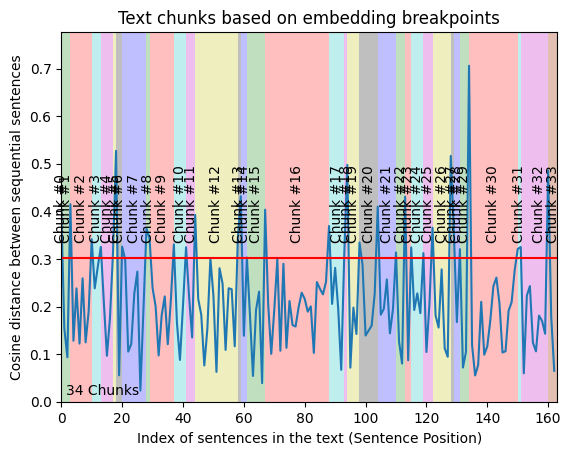



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 1.pdf


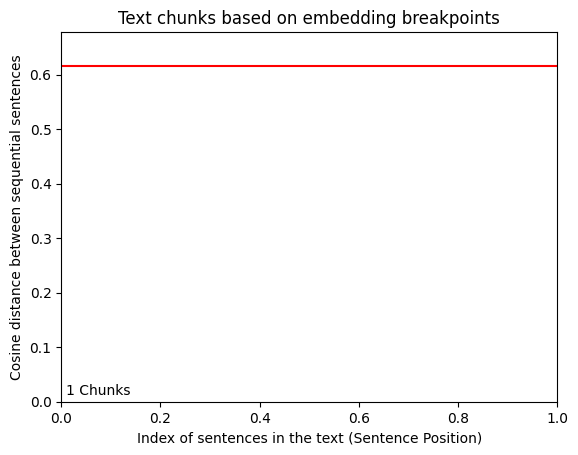



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 2.pdf


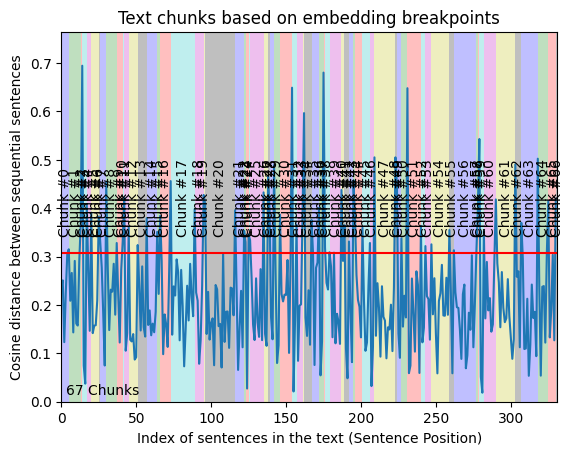



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 3.pdf


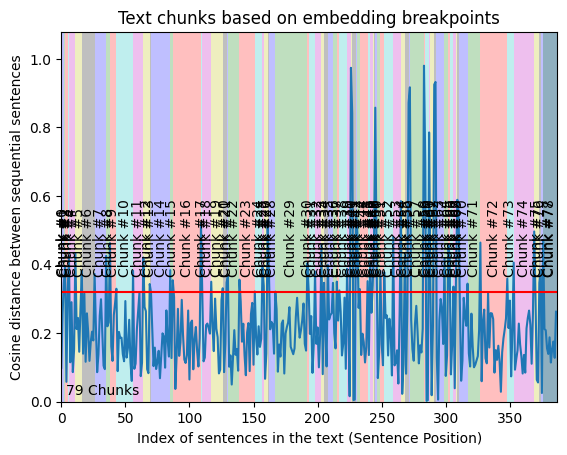



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 4.pdf


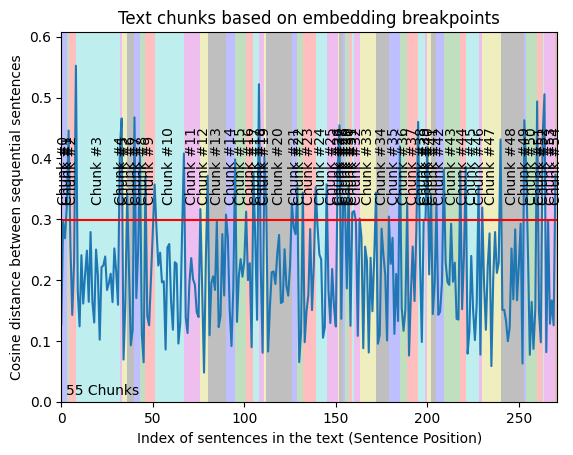



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 5.pdf


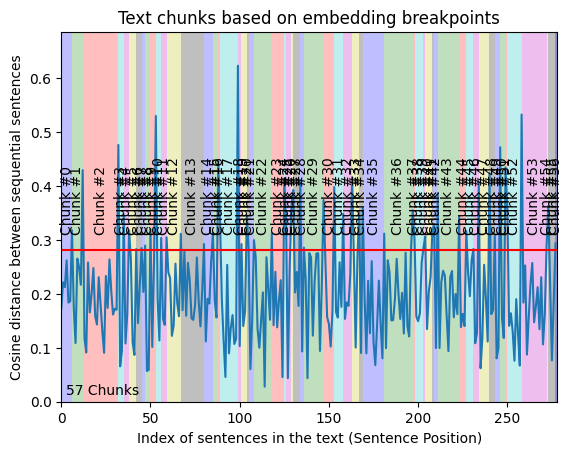



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 6.pdf


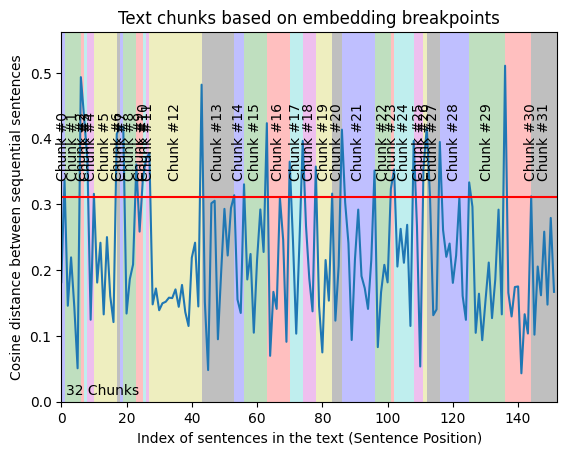



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 8.pdf


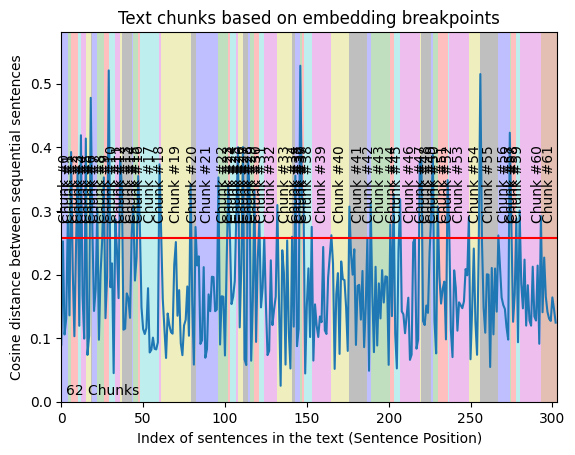



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 9.pdf


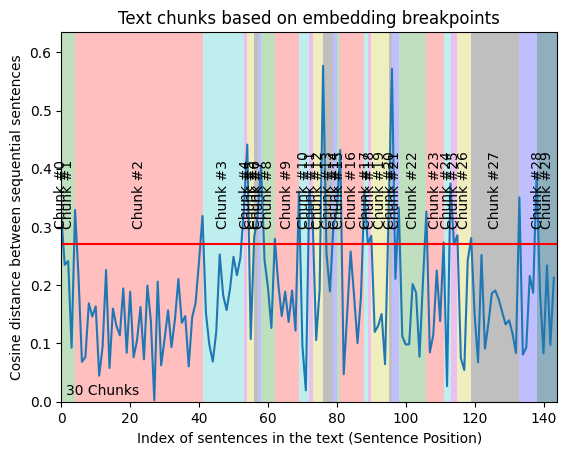



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 10.pdf


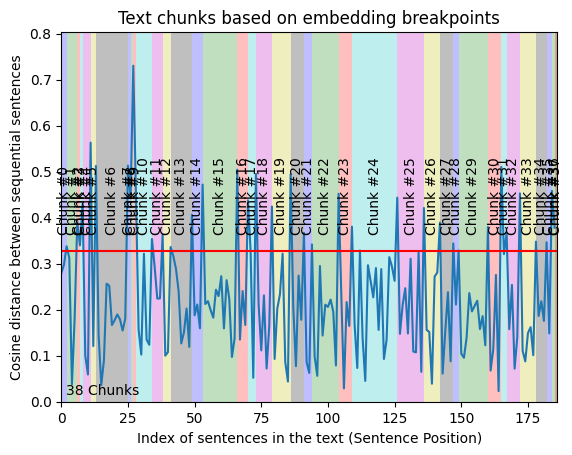



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 11.pdf


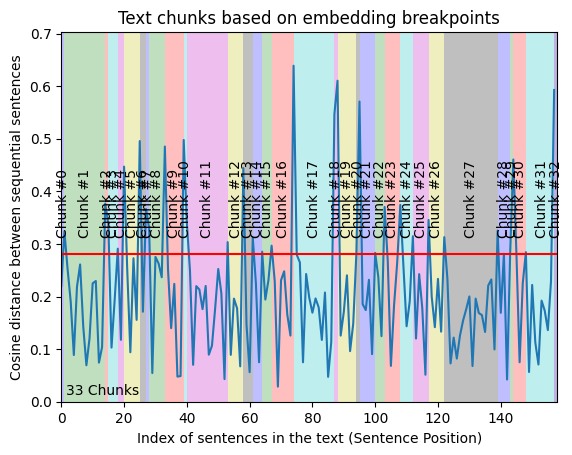



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 12.pdf


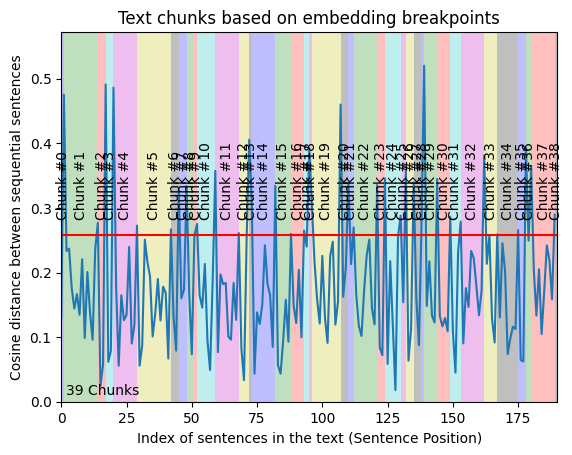



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 13.pdf


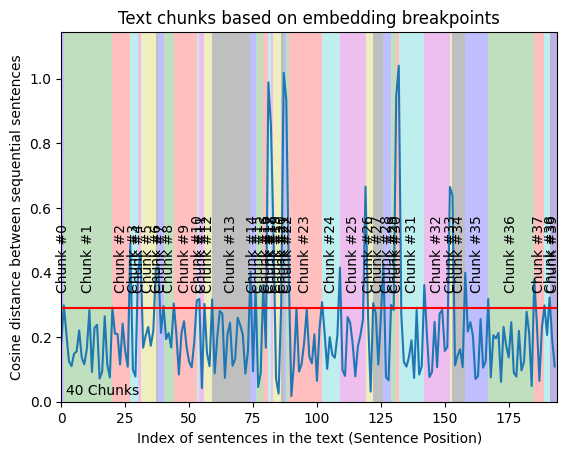



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 15.pdf


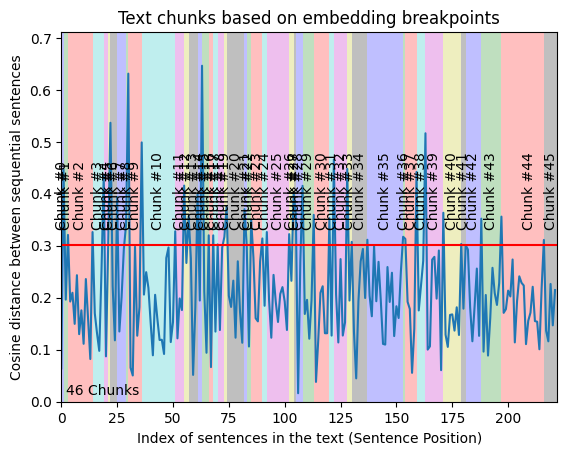



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 16.pdf


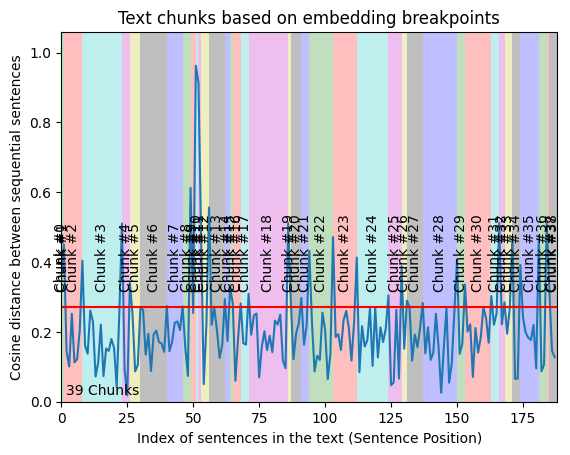



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 17.pdf


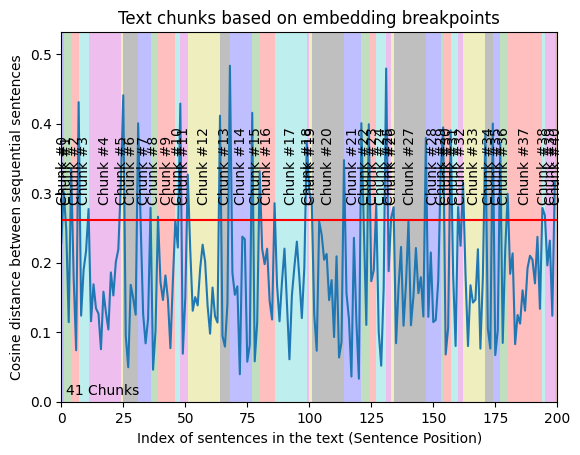



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 18.pdf


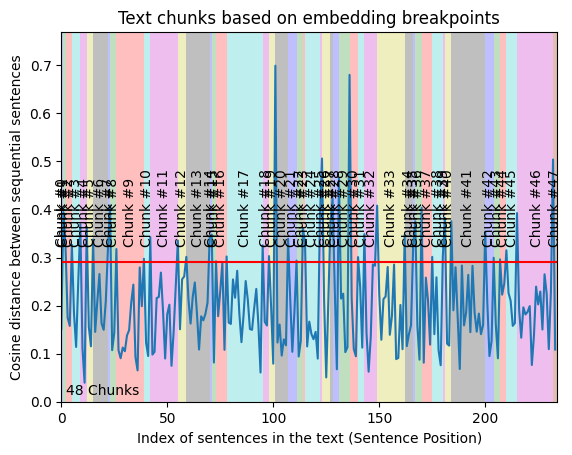



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 19.pdf


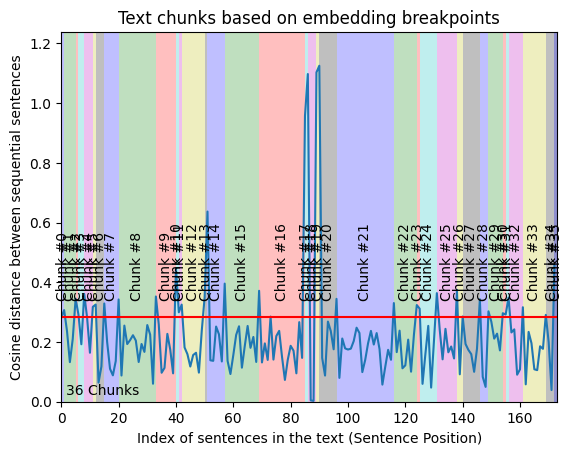



Document name: War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 20.pdf


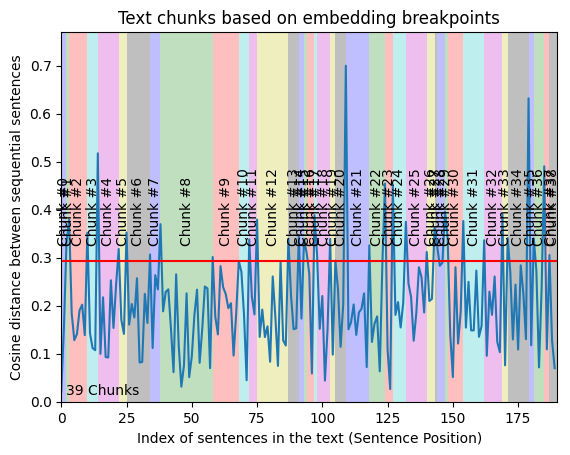

In [ ]:
chunks_metadata = sentences_semantic_chunking(sentences_metadata, percentile_threshold=80, max_tokens_per_chunk=800, show_plot=True)
#chunks_metadata = sentences_semantic_chunking(sentences_metadata, percentile_threshold=80, show_plot=True)

In [ ]:
random.sample(chunks_metadata, k=1)

[{'sentences_sources': [{'document_name': 'War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 3.pdf',
    'page_number': 13}],
  'chunk': 'Russia’s former president and current member of the Russian Security Council, Dmitry Medvedev, was even more blunt in describing the eliminationist goals of the invasion, stating on his Telegram channel that',
  'chunk_word_count': 31,
  'chunk_token_count': 51.75,
  'chunk_char_count': 207}]

In [ ]:
df = pd.DataFrame(chunks_metadata)
#df.head()
df.describe().round(2)

,chunk_word_count,chunk_token_count,chunk_char_count
count,825.00,825.00,825.00
mean,125.93,202.19,808.78
std,107.55,174.38,697.52
min,1.00,0.50,2.00
25%,47.00,73.50,294.00
50%,95.00,151.75,607.00
75%,170.00,271.00,1084.00
max,509.00,802.50,3210.00


### Filter short chunks of text
Here we filter out very short chunks because they may not contain much useful information.

In [ ]:
# Show random chunks with under N tokens in length
min_token_length = 15

#for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
for row in df[df["chunk_token_count"] <= min_token_length].iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["chunk"]}')

Chunk token count: 14.75 | Text: I certainly did not foresee them in 2014, or in early 2022.
Chunk token count: 6.5 | Text: I’m not under bombardment.
Chunk token count: 13.75 | Text: This is a war for Ukraine’s sovereignty and its future.
Chunk token count: 14.25 | Text: The ability to invade does not automatically lead to war.
Chunk token count: 0.5 | Text:  .
Chunk token count: 0.5 | Text:  .
Chunk token count: 12.75 | Text: The existence of Ukraine is deadly for Ukrainians .
Chunk token count: 0.5 | Text:  .
Chunk token count: 0.5 | Text:  .
Chunk token count: 0.5 | Text:  .
Chunk token count: 11.5 | Text:  .  .   I do not rule out such a possibility .
Chunk token count: 0.5 | Text:  .
Chunk token count: 0.5 | Text:  .
Chunk token count: 0.5 | Text:  .
Chunk token count: 8.5 | Text: But they also had their own ideas.
Chunk token count: 13.0 | Text: It had been Ukraine’s possession of nuclear weapons.
Chunk token count: 6.25 | Text: Putin invaded regardless.
Chunk token count: 13.0 

In [ ]:
# Filter the DataFrame for rows with under 30 tokens
filtered_chunks_metadata = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
random.sample(filtered_chunks_metadata, k=1)

[{'sentences_sources': [{'document_name': 'War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 10.pdf',
    'page_number': 2},
   {'document_name': 'War in Ukraine: Conflict, Strategy, and the Return of a Fractured World - Chapter 10.pdf',
    'page_number': 3}],
  'chunk': 'This was accompanied by an invitation to Putin to attend a summit later that year. The goal of establishing a more “stable and predictable” bilateral relationship was tested in April, when Russia massed tens of thousands of troops along Ukraine’s border. While calling for Russia to pull back its forces, the administration calculated that engaging Putin would help ease tensions and might create opportunities to address some long-standing irritants. The Geneva summit on June16, 2021, appeared to validate this approach: a businesslike meeting with Putin resulted in commitments to restore or establish dialogues on strategic stability and cybersecurity. Over the following months, as these d

In [ ]:
# Save embeddings to file
chunks_df = pd.DataFrame(filtered_chunks_metadata)
save_path = "chunks_embeddings_df.csv"
chunks_df.to_csv(save_path, index=False)

In [ ]:
# Import saved file and view
chunks_df = pd.read_csv(save_path)

In [ ]:
#chunks_df.head()
chunks_df.describe().round(2)

,chunk_word_count,chunk_token_count,chunk_char_count
count,791.00,791.00,791.00
mean,131.17,210.65,842.61
std,106.76,173.14,692.56
min,6.00,15.25,61.00
25%,53.00,82.88,331.50
50%,99.00,159.25,637.00
75%,175.00,280.88,1123.50
max,509.00,802.50,3210.00




---


## **4. Text embedding**


---



In this section we store the chunks of text in a **Chroma Database**, where they are encoded using the `langchain_embedding_model`, defined at section "*1. Embedding models and LLMs loading*".

The advantage of using a **Vectorial Database**, instead of a simple DataFrame, are:

*   Handle huge amount of data
*   Efficient and advanced retrieval
*   Efficient manipulation of high-dimensional data (e.g., text embedding)
*   High scalability
*   Metadata handling

> Note: in RAG using a Vectorial Database, in place of a DataFrame, is suggested when we have to cope with big amount of text.

> Note: Chroma has a bug in the search part (done in the next section), when you run it the first time it finds all different documents, but if you run it again, very often it finds more times the same documents. Apparently it is a problem related to how Chroma is implemented. Unfortunately, if this happens, the only way to solve it is to restart the session and to run the whole code all over again.

### Chroma vector database (chunks embedding)

In [ ]:
import pandas as pd
from langchain.docstore.document import Document
from langchain.vectorstores import Chroma
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from transformers import AutoModel, AutoTokenizer

def create_chroma_database(chunks_embeddings_df, embedding_model):
    """
        Creates a Chroma database from chunks embeddings DataFrame using
        the specified embedding model to represent each chunk as a vector
        within the vectorial database.
    """

    # Convert DataFrame rows to Documents
    docs = []

    # Iterate over each row in the DataFrame
    for _, row in chunks_embeddings_df.iterrows():
        # Create a Document object with page content and metadata
        doc = Document(
            page_content=row["chunk"],
            metadata={
                "sentences_sources": row["sentences_sources"],
                "chunk_word_count": row["chunk_word_count"],
                "chunk_token_count": row["chunk_token_count"],
                "chunk_char_count": row["chunk_char_count"]
            }
        )

        # Add the Document to the list
        docs.append(doc)

    # Initialize Chroma Database from documents and embedding model
    chunks_db = Chroma.from_documents(
        documents=docs,
        embedding=embedding_model
    )

    return chunks_db

In [ ]:
# Store the chunks (from the DataFrame) in the Chroma Database
chunks_db = create_chroma_database(chunks_df, langchain_embedding_model)



---


## **5. Text Retrieval**


---



In this section we define the **Chunks Retrieval Pipeline**. In particular, our retrieval pipeline is composed by two main frameworks:

*   Multiquery Retrieval
*   Contextual Compression

**Multiquery Retrieval**
*   Nuances in the question can lead to different results if the question does not capture the embeddings semantically well.
To handle this issue, MultiQuery Retriever creates variations of the question and thus goes against the database.
*   Multiquery retrieval involves using multiple queries instead of a single query to retrieve information from a dataset or a database. Each query may focus on different aspects or dimensions of the information need, and results from multiple queries are typically combined or analyzed to provide a comprehensive answer or solution.
*   Multiquery retrieval offers significant advantages over simple query retrieval by leveraging multiple queries to enhance precision, coverage, relevance, and adaptability in addressing complex information needs effectively.

> Note: in our case to implement Multiquery Retrieval we exploited the `langchain` libraries. However, the model `retrieval_llm` we used for multiquery retrieval was not imported directly from the langchain libraries. For this reason, we needed to adapt it (by wrapping it) in such a way we could integrate it with the langchain pipeline.

**Contextual Compression**
*   Contextual compression consists in condensing or summarizing information from a given context while retaining its essential meaning and relevance. This technique is particularly useful in natural language processing (NLP) and information retrieval tasks, where reducing the size or complexity of text while preserving its informational value is crucial.
*   Contextual compression plays a pivotal role in optimizing the retrieval and generation processes within RAG frameworks by improving input quality, enhancing processing efficiency, and facilitating coherent and informative outputs. These advantages contribute to the robustness, effectiveness, and user-centricity of RAG applications across diverse domains and applications.
*   Moreover, contextual compression techniques play a crucial role in **mitigating hallucinations** by ensuring that only validated and contextually supported information is processed and utilized for generation tasks.
*   To implement the contextual compression in our RAG pipeline we used the model `retrieval_llm` as well (as for Multiquery Retrieval). However, in this case the integration of the model in the langchain pipeline for the compression was much harder (wrapping stuff was not enough!), and it was not as flexible as we wanted.
*   For this reason we implemented the contextual compression from scratch, and then we integrated it in the RAG pipeline.
* In particular we defined 2 different methods for contextual compression (inspired to the langchain contextual compression), which we called:
    *   **Heavy contextual compression**
    *   **Light contextual compression**

> Note: more details about all these techniques, pros and cons, and some considerations about the integration with langchain will be provided later in the rest of this section.

### Simple Query Retrieval (Similarity Search)

Here we show just an example of the performance of the **Simple Query Retrieval**, which is based on the standard similarity search. We do this in order to have a baseline to compare how the performance increases with the Multiquery Retrieval defined in the next point, which is the one that we actually use for our RAG pipeline.

In [ ]:
# Test the similarity_search_with_score function
query = "Why did Putin invade Ukraine?"

results = chunks_db.similarity_search_with_score(query)

# Sort the results in decreasing order based on the similarity score
top_k = 5
top_results = sorted(results, key=lambda x: x[1], reverse=True)#[:top_k]

for doc, score in top_results:
    print("Score:", score)
    print("Content:", doc.page_content)
    print("Metadata:", doc.metadata)
    print()

Score: 82.31887817382812
Content: Yet a quasi-genocidal conflict was not Putin’s first choice for achieving that aim, even if, today, such barbarism seems to fit him like a glove. Between 2004 and 2022, Putin used an array of tactics—from poisoning and political meddling to covert wars and limited land grabs—against Ukraine. He eventually went for broke because those tactics were producing disastrous strategic results. Putin’s interference in Ukrainian politics in 2004–2005 backfired by triggering the Orange Revolution, just the sort of pro-democracy, pro-Western movement he surely hoped to avoid. Nine years later, Putin succeeded in coercing a more pro-Russian leader into jilting Europe and bringing Ukraine closer to Moscow—only to set off another popular movement, the Revolution of Dignity, that brought that government down. Putin responded by seizing Crimea and destabilizing eastern Ukraine. But in conquering a peninsula and roiling a region, he lost a country. The war encouraged Ky

### Multiquery Retrieval

Here we define the function `multiqueries_generator` that performs **Multiquery Generation**, i.e., which generates multiple variants of the original query/question provided. To generate such new queries, we exploit the model `retrieval_llm`, defined at section "*1. Embedding models and LLMs loading*", at which we pass the original query and a custom prompt specific for this task.

> Note: in this case for the model we use a high temperature in order to allow it to have a certain degree of freedom in generating the new questions.

In [ ]:
from typing import List
from langchain_core.output_parsers import BaseOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

def extract_questions(queries: List[str]) -> List[str]:
    """
        Processes the queries generated by the retrieval LLM and extracts the
        list of alternative questions generated.
    """

    questions = []
    for query in queries:
        # Check if the line ends with a question mark (?)
        if query.endswith("?"):
            # Remove any leading or trailing whitespace
            question = query.strip()

            # Remove prefix like "**Alternative <number>:**"
            if question.startswith("**Alternative"):
                colon_index = question.find(":")  # Find the first colon
                if colon_index != -1:
                    question = question[colon_index + 1:].strip()  # Remove prefix and trim

            # Check if the question starts with a known marker or is just a question
            if question[0] in ['>', '*', '-']:
                question = question[1:].strip()  # Remove the starting marker
            questions.append(question)
    return questions



QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five short
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions preceded and separated by newlines.
    Original question: {question}
    Alternative 1: Rephrase the question using synonyms.
    Alternative 2: Simplify the question while keeping the original meaning.
    Alternative 3: Expand the question to include additional related details.
    Alternative 4: Ask the question from a different perspective or context.
    Alternative 5: Create a more specific version of the question."""
)



def multiqueries_generator(question: str) -> List[str]:
    """
        Exploits a large language model (LLM) to generate multiple alternative
        queries/questions based on a given user question.
    """

    MAX_RETRIES = 5
    retries = 0

    # Try to generate at least 3 new questions for at most MAX_RETRIES times
    while retries < MAX_RETRIES:
        # Format the prompt with the question
        prompt = QUERY_PROMPT.format(question=question)

        # Tokenize the input
        inputs = retrieval_tokenizer(prompt, return_tensors="pt").to("cuda")

        # Generate responses with max_new_tokens set
        with torch.no_grad():
            outputs = retrieval_llm.generate(
                **inputs,
                max_new_tokens=400,
                do_sample=True,
                temperature=0.7,
                top_p=0.95
            )

        # Decode and parse responses
        response_text = retrieval_tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Split by newlines and filter out empty lines and parts of the prompt
        lines = response_text.split("\n")
        queries = []
        for line in lines:
            line = line.strip()
            if line and not line.startswith("Original question:"):
                queries.append(line)

        # Extract questions
        extracted_questions = extract_questions(queries)

        if len(extracted_questions) > 2:    # It must generate at least 3 new questions
            extracted_questions = [str(question)] + extracted_questions  # Prepend the original question to the extracted questions
            return extracted_questions

        retries += 1

    # Failed to generate new questions
    print(f"Failed to generate valid queries after {MAX_RETRIES} attempts")
    return None

In [ ]:
# Test the multiqueries_generator function
question = "Why did Putin invade Ukraine?"
queries = multiqueries_generator(question)

print("Generated Queries:")
for i, query in enumerate(queries, start=1):
    print(f"Alternative {i}: {query}")

Generated Queries:
Alternative 1: Why did Putin invade Ukraine?
Alternative 2: Why were the actions of the Russian government deemed to be aggressive and threatening by Ukrainian leaders and international organizations?
Alternative 3: What are the main reasons behind Russia's invasion of Ukraine?
Alternative 4: What were the specific events or actions leading up to the Russian invasion of Ukraine? How did these events impact the international community?
Alternative 5: What is the broader context of the conflict between Russia and Ukraine, and why did Putin choose to invade?
Alternative 6: What were the immediate and long-term consequences of Russia's annexation of Crimea in 2014?


Here we define the function `retrieve_relevant_chunks` that performs **Multiquery Retrieval**, i.e., which retrieves the k top-most relevant chunks by exploiting the `multiqueries_generator` previously defined.

To find the k top-most relevant chunks we compute the embedding of the original query and the embedding of each chunk by using the `general_embedding_model`, defined at section "*1. Embedding models and LLMs loading*", and we find those retrieved chunks whose distance is closer to the one of the original question embedding.

> Note: in our case, we cannot directly use the `retrieval_llm` in the langchain MultiQueryRetrieval pipeline, because it was not imported from the langchain libraries. Instead, we need to wrap the function `multiqueries_generator` previously defined, which uses such model, in a class `QueryGenerator` suitable for being used by the langchain MultiQueryRetriever pipeline.

> Note a better approach would have been to directly import the model from langchain, in such a way that it could have been used directly without the need to wrap it.
As example, see: [link](https://medium.com/@mohammed97ashraf/building-a-retrieval-augmented-generation-rag-model-with-gemma-and-langchain-a-step-by-step-f917fc6f753f).

In [ ]:
from langchain_core.runnables import RunnableLambda
from langchain.retrievers.multi_query import MultiQueryRetriever
from typing import Optional, Tuple, Callable

class QueryGenerator(RunnableLambda):
    """
        This class wraps a function generator_function in order to adapt it to
        the langchain pipeline.
    """

    def __init__(self, generator_function):
        super().__init__(func=generator_function)
        self.generator_function = generator_function

    def run(self, question):
        return self.generator_function(question)


def retrieve_relevant_chunks(question: str, embedding_model, max_chunks: Optional[int] = None) -> Tuple[List[Document], List[float]]:
    """
        Retrieves relevant chunks of text from a vector database based on a
        user's question. It utilizes a multi-query retrieval approach to find
        the most relevant chunks.

        If a maximum number of chunks is specified (max_chunks), the function
        returns only that many results. Otherwise, it returns all retrieved chunks.

        Additionally, it computes the cosine similarity of each retrieved chunk
        with respect to the query, sorts the retrieved chunks in decreasing
        order, and returns the top-k chunks along with their similarity scores.
    """

    # Initialize MultiQueryRetriever
    retriever = MultiQueryRetriever(
        retriever=chunks_db.as_retriever(),
        llm_chain=QueryGenerator(multiqueries_generator),
        parser_key="lines"
    )

    # Get relevant documents (chunks)
    all_chunks = retriever.get_relevant_documents(question)

    # Define the embedding function using the passed embedding_model
    def embedding_model_wrapper(text: str) -> List[float]:
        return embedding_model.encode(text, convert_to_tensor=True).cpu().numpy()

    # Compute cosine similarities between the query and the chunks
    query_embedding = embedding_model_wrapper(question)
    chunks_embeddings = [embedding_model_wrapper(chunk.page_content) for chunk in all_chunks]
    similarities = cosine_similarity([query_embedding], chunks_embeddings)[0]

    # Create a DataFrame with chunks and their similarities
    chunks_df = pd.DataFrame({
        'chunk': all_chunks,
        'similarity': similarities
    }).sort_values(by='similarity', ascending=False)

    # Limit the number of returned chunks
    if max_chunks is not None:
        top_chunks_df = chunks_df.head(max_chunks)
    else:
        top_chunks_df = chunks_df

    # Extract top chunks and their similarity scores
    top_chunks = top_chunks_df['chunk'].tolist()
    top_similarities = top_chunks_df['similarity'].tolist()

    return top_chunks, top_similarities

In [ ]:
# Test the retrieve_relevant_chunks function
question = "Why did Putin invade Ukraine?"

# Print the top-k unique chunks retrieved
top_chunks, top_similarities = retrieve_relevant_chunks(question, general_embedding_model, max_chunks=10)
print(len(top_chunks))

for chunk, score in zip(top_chunks, top_similarities):
    print(f"Chunk Score: {score}")
    print(f"Chunk Content: {chunk.page_content}")
    print(f"Metadata: {chunk.metadata}")
    print("\n")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


10
Chunk Score: 0.4912489056587219
Chunk Content:  .  .   Specifically, I am talking about America’s obsession with bringing Ukraine into NATO and making it a Western bulwark on Russia’s border. The Biden administration was unwilling to eliminate that threat through diplomacy and indeed in 2021 recommitted the United States to bringing Ukraine into NATO. Putin responded by invading Ukraine on February4thof this year.16 Mearsheimer’s argument and its implications are simple, straightforward, and easy to understand. NATO expansion was threatening to Russia; Russia had no choice but to invade Ukraine in 2014 and again in 2022 to prevent further expansion. To work, however, this explanation has to ignore a lot of history and much of what Putin himself has said about his motivations for invading Ukraine. In Mearsheimer’s telling, NATO expansion—pushed relentlessly by Washington—was a consistent and growing source of tension between Russia and the West over the last thirty years. In truth, a

### Contextual Compression

Here we define the function `summarize_text` that allows to summarize and compress each chunk into a compressed chunk , which only contains those information of the original chunk that are relevant for the specific question we have.

To summarize such chunks, we exploit the model `retrieval_llm`, defined at section "*1. Embedding models and LLMs loading*", at which we pass the original chunks and a custom prompt specific for this task.

> Note: in this case we could also use a more suitable model specifically pretrained for the summarization task. However, to save memory space on the GPU VRAM we decided to use the same model we used for generating multiple queries.  

In [ ]:
"""
def filter_relevant_sentences(text: str, question: str, summarizer_llm, summarizer_tokenizer, top_k: int = 5) -> str:
    sentences = text.split('.')
    inputs = summarizer_tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = summarizer_llm(**inputs)
        logits = outputs.logits
        scores = logits[:, summarizer_tokenizer.convert_tokens_to_ids(summarizer_tokenizer.pad_token)].squeeze()

    top_indices = torch.topk(scores, top_k, largest=False).indices.tolist()

    # Flatten the list of lists into a single list of integers
    top_indices = [index for sublist in top_indices for index in sublist]

    # Filter out-of-range indices
    top_indices = [index for index in top_indices if index < len(sentences)]

    # Collect filtered sentences based on top indices
    filtered_sentences = []
    for index in top_indices:
        filtered_sentences.append(sentences[index])

    return ' '.join(filtered_sentences)
"""

'\ndef filter_relevant_sentences(text: str, question: str, summarizer_llm, summarizer_tokenizer, top_k: int = 5) -> str:\n    sentences = text.split(\'.\')\n    inputs = summarizer_tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)\n\n    with torch.no_grad():\n        outputs = summarizer_llm(**inputs)\n        logits = outputs.logits\n        scores = logits[:, summarizer_tokenizer.convert_tokens_to_ids(summarizer_tokenizer.pad_token)].squeeze()\n\n    top_indices = torch.topk(scores, top_k, largest=False).indices.tolist()\n\n    # Flatten the list of lists into a single list of integers\n    top_indices = [index for sublist in top_indices for index in sublist]\n\n    # Filter out-of-range indices\n    top_indices = [index for index in top_indices if index < len(sentences)]\n\n    # Collect filtered sentences based on top indices\n    filtered_sentences = []\n    for index in top_indices:\n        filtered_sentences.append(sentences[in

In [ ]:
CONTEXTUAL_COMPRESSION_PROMPT = """
You are an expert summarizer. Your task is to compress the following text while
preserving its key information and context.
Make sure your answer is a concise and complete summary containing information
relevant to the given question.
If the text does not provide any information for the given question just
generate -1.

Here is the question and the text:

Question: {question}
Text: {text}

Summary:
"""



def summarize_text(text: str, question: str, summarizer_llm, summarizer_tokenizer, max_new_tokens: int = 512) -> str:
    """
        Summarizes the provided text based on a specific question using a
        summarizer language model and tokenizer.
    """

    # Define the prompt template with the question and the text to be summarized
    prompt = CONTEXTUAL_COMPRESSION_PROMPT.format(question=question, text=text)

    # Tokenize the prompt with a maximum length and enable truncation
    inputs = summarizer_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(device)

    # Generate the summary using the llm with specific generation parameters
    summary_ids = summarizer_llm.generate(
        inputs.input_ids,
        max_new_tokens=max_new_tokens,  # Maximum number of new tokens to generate
        num_beams=4,                    # Number of beams for beam search
        length_penalty=2.0,             # Penalty for the length of the generated text
        early_stopping=True             # Stop generation early when an end-of-sequence token is reached
    )

    # Decode the generated summary IDs to text
    output = summarizer_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Extract the summary text starting after the "Summary:" marker
    summary_start = output.find("Summary:") + len("Summary:")
    summary_text = output[summary_start:].strip()

    # Split the summary text into lines
    lines = summary_text.splitlines()

    # Filter out any lines starting with "Sure,"
    filtered_lines = [line for line in lines if not line.startswith("Sure,")]

    # Join the filtered lines back into a single string
    filtered_summary = "\n".join(filtered_lines).strip()

    return filtered_summary

**Heavy compression:** first compresses all chunks stored in the vector database, then performs retrieval on the compressed chunks.
*   Pros:
    *   Improves the search for the retrieval task, since now the search is done on compressed chunks which only contains information relevant for the given query.
    *   Removes noise and useless information from the text.
    *   Compresses the chunks size allowing to retreive much more chunks to pass to our `rag_llm`.
*   Cons:
    *   Very slow, since `retrieval_llm` has to generate a summary for all the possible chunks we have.
    *   Does not improve RAG results so much.
    
> Considerations: in a costs/benefits comparison, in general, it is not worth to include this compression in the final RAG pipeline, at least that we do not have a lot of different source documents to consult for a given question, thus requiring to retrieve as much chunks as possible (since we know that the context window of our `rag_llm` is not unlimited).

> Note: in the code below we commented the code to test the `retrieve_relevant_chunks_with_heavy_compression` in order to avoid slowing down the execution of this notebook. However, you can uncomment the code below if you want to test it!



In [ ]:
# Define the modified retrieve_relevant_chunks function
def retrieve_relevant_chunks_with_heavy_compression(question: str, embedding_model, max_chunks: Optional[int] = None) -> Tuple[List[str], List[str], List[float]]:
    # Initialize MultiQueryRetriever
    retriever = MultiQueryRetriever(
        retriever=chunks_db.as_retriever(),
        llm_chain=QueryGenerator(multiqueries_generator),
        parser_key="lines"
    )

    # Get relevant documents (chunks)
    all_chunks = retriever.get_relevant_documents(question)

    # Wrap the embedding_model
    def embedding_model_wrapper(text: str) -> List[float]:
        return embedding_model.encode(text, convert_to_tensor=True).cpu().numpy()

    # Perform contextual compression using retrieval_llm
    compressed_chunks = [summarize_text(chunk.page_content, question, retrieval_llm, retrieval_tokenizer) for chunk in all_chunks]

    # Compute cosine similarities between the query and the compressed chunks
    query_embedding = embedding_model_wrapper(question)
    compressed_chunks_embeddings = [embedding_model_wrapper(chunk) for chunk in compressed_chunks]
    similarities = cosine_similarity([query_embedding], compressed_chunks_embeddings)[0]

    # Create DataFrames with original and compressed chunks along with their similarities
    chunks_df = pd.DataFrame({
        'chunk': [chunk.page_content for chunk in all_chunks],
        'compressed_chunk': compressed_chunks,
        'similarity': similarities
    }).sort_values(by='similarity', ascending=False)

    # Limit the number of returned chunks
    if max_chunks is not None:
        top_chunks_df = chunks_df.head(max_chunks)
    else:
        top_chunks_df = chunks_df

    # Extract top chunks and their similarity scores
    top_full_chunks = top_chunks_df['chunk'].tolist()
    top_compressed_chunks = top_chunks_df['compressed_chunk'].tolist()
    top_similarities = top_chunks_df['similarity'].tolist()

    return top_full_chunks, top_compressed_chunks, top_similarities

In [ ]:
# Uncomment if you want to test chunks compression -> Note: it is very slow
"""
# Test the retrieve_relevant_chunks_with_heavy_compression function
question = "Why did Putin invade Ukraine?"

# Retrieve the top-k unique chunks
top_full_chunks, top_compressed_chunks, top_similarities = retrieve_relevant_chunks_with_heavy_compression(
    question,
    general_embedding_model,
    max_chunks=10
)

# Print the number of top chunks retrieved
print(f"Number of top chunks retrieved: {len(top_chunks)}")

# Print the retrieved chunks (both full and compressed)
for full_chunk, compressed_chunk, similarity in zip(top_full_chunks, top_compressed_chunks, top_similarities):
    print(f"Chunk Score: {similarity}")
    print(f"Full Chunk Content: {full_chunk}")
    print(f"Compressed Chunk Content: {compressed_chunk}")
    print("\n")
"""

'\n# Test the retrieve_relevant_chunks_with_heavy_compression function\nquestion = "Why did Putin invade Ukraine?"\n\n# Retrieve the top-k unique chunks\ntop_full_chunks, top_compressed_chunks, top_similarities = retrieve_relevant_chunks_with_heavy_compression(\n    question,\n    general_embedding_model,\n    max_chunks=10\n)\n\n# Print the number of top chunks retrieved\nprint(f"Number of top chunks retrieved: {len(top_chunks)}")\n\n# Print the retrieved chunks (both full and compressed)\nfor full_chunk, compressed_chunk, similarity in zip(top_full_chunks, top_compressed_chunks, top_similarities):\n    print(f"Chunk Score: {similarity}")\n    print(f"Full Chunk Content: {full_chunk}")\n    print(f"Compressed Chunk Content: {compressed_chunk}")\n    print("\n")\n'

**Light compression:** performs normal chunks retrieval, then compresses only the top chunks retrieved.
*   Pros:
    *   Removes noise and useless information from the text.
    *   Compresses the chunks allowing to retrieve much more chunks to pass to our `rag_llm`.
*   Cons:
    *   Faster than the previous approach, but still slow.
    *   Does not improve RAG results so much.
   
> Considerations: same considerations as for the previous approach, also considering that in this case even if faster, the performance are slightly worst than before.

> Note: in the code below we commented the code to test the `retrieve_relevant_chunks_with_heavy_compression` in order to avoid slowing down the execution of this notebook. However, you can uncomment the code below if you want to test it!

In [ ]:
def retrieve_relevant_chunks_with_light_compression(question: str, embedding_model, max_chunks: Optional[int] = None) -> Tuple[List[str], List[str], List[float]]:
    # Initialize MultiQueryRetriever
    retriever = MultiQueryRetriever(
        retriever=chunks_db.as_retriever(),
        llm_chain=QueryGenerator(multiqueries_generator),
        parser_key="lines"
    )

    # Get relevant documents (chunks)
    all_chunks = retriever.get_relevant_documents(question)

    # Wrap the embedding_model
    def embedding_model_wrapper(text: str) -> List[float]:
        return embedding_model.encode(text, convert_to_tensor=True).cpu().numpy()

    # Compute cosine similarities between the query and the chunks
    query_embedding = embedding_model_wrapper(question)
    chunks_embeddings = [embedding_model_wrapper(chunk.page_content) for chunk in all_chunks]
    similarities = cosine_similarity([query_embedding], chunks_embeddings)[0]

    # Create DataFrame with chunks and their similarities
    chunks_df = pd.DataFrame({
        'chunk': [chunk.page_content for chunk in all_chunks],
        'similarity': similarities
    })

    # Sort chunks by similarity and limit the number of returned chunks
    chunks_df = chunks_df.sort_values(by='similarity', ascending=False)
    if max_chunks is not None:
        chunks_df = chunks_df.head(max_chunks)

    # Extract top chunks and their similarity scores
    top_full_chunks = chunks_df['chunk'].tolist()
    top_similarities = chunks_df['similarity'].tolist()

    # Perform contextual compression only on the top chunks
    top_compressed_chunks = [summarize_text(chunk, question, retrieval_llm, retrieval_tokenizer) for chunk in top_full_chunks]

    return top_full_chunks, top_compressed_chunks, top_similarities

In [ ]:
# Uncomment if you want to test chunks compression -> Note: it is quite slow
"""
# Test the function retrieve_relevant_chunks_with_light_compression
question = "Why did Putin invade Ukraine?"

# Retrieve the top-k unique chunks
top_full_chunks, top_compressed_chunks, top_similarities = retrieve_relevant_chunks_with_light_compression(
    question,
    general_embedding_model,
    max_chunks=10
)

# Print the number of retrieved chunks
print(f"Number of Chunks Retrieved: {len(top_full_chunks)}\n")

# Print the retrieved chunks (both full and compressed)
for full_chunk, compressed_chunk, similarity in zip(top_full_chunks, top_compressed_chunks, top_similarities):
    print(f"Chunk Score: {similarity}")
    print(f"Full Chunk Content:\n{full_chunk}\n")
    print(f"Compressed Chunk Content:\n{compressed_chunk}\n")
    print("\n")
"""

'\n# Test the function retrieve_relevant_chunks_with_light_compression\nquestion = "Why did Putin invade Ukraine?"\n\n# Retrieve the top-k unique chunks\ntop_full_chunks, top_compressed_chunks, top_similarities = retrieve_relevant_chunks_with_light_compression(\n    question,\n    general_embedding_model,\n    max_chunks=10\n)\n\n# Print the number of retrieved chunks\nprint(f"Number of Chunks Retrieved: {len(top_full_chunks)}\n")\n\n# Print the retrieved chunks (both full and compressed)\nfor full_chunk, compressed_chunk, similarity in zip(top_full_chunks, top_compressed_chunks, top_similarities):\n    print(f"Chunk Score: {similarity}")\n    print(f"Full Chunk Content:\n{full_chunk}\n")\n    print(f"Compressed Chunk Content:\n{compressed_chunk}\n")\n    print("\n")\n'



---


## **6. LLM text generation**


---


In this section we just show how our `rag_llm` (`LLama 3 8b Instruct`), defined at section "*1. Embedding models and LLMs loading*", performs by default when we provide it no prompt nor context infromation. We do this in order to have a baseline to compare how the performance increase in the full RAG pipeline where we both provide a prompt and the retrieved context information.

### Generate text with our LLM (default prompt and no context information)

In [ ]:
input_text = "Why did Putin invade Ukraine?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [{
    "role": "user",
    "content": input_text
}]

# Apply the chat template
prompt = rag_tokenizer.apply_chat_template(
    conversation=dialogue_template,
    tokenize=False,
    add_generation_prompt=True
)

print(f"\nPrompt (formatted):\n{prompt}")

Input text:
Why did Putin invade Ukraine?

Prompt (formatted):
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Why did Putin invade Ukraine?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [ ]:
# Tokenize the input text (turn it into numbers) and send it to the GPU
input_ids = rag_tokenizer(
    prompt,
    return_tensors="pt"
).to("cuda")

# Generate outputs from local LLM
outputs = rag_llm.generate(
    **input_ids,
    max_new_tokens=256
)

print(f"Model output (tokens):\n{outputs[0]}\n")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Model output (tokens):
tensor([128000, 128000, 128006,    882, 128007,    271,  10445,   1550,  21810,
         75272,  19278,     30, 128009, 128006,  78191, 128007,    271,    791,
         30215,    315,  19278,    555,   8524,     11,   6197,    555,   4900,
         36011,  21810,     11,    374,    264,   6485,    323,  62387,    582,
         25489,   4360,    449,   5370,  65931,    323,   9547,   6532,     13,
          5810,    527,   1063,    315,    279,   1401,   8125,   1473,     16,
            13,   3146,  50083,    950,    323,  13042,  20405,  96618,  19278,
           323,   8524,    617,    264,   6222,   3925,    323,  13042,  28948,
            11,    449,   1690,  31704,   5493,   8430,    264,   3831,   3717,
           311,   8690,   7829,    323,   4221,     13,  21810,    706,   3629,
         46728,    279,  12939,    315,  47995,   8690,  62290,  10977,    323,
         22923,   8690,   7829,    304,  19278,    627,     17,     13,   3146,
            36,  

In [ ]:
# Decode the output tokens to text
outputs_decoded = rag_tokenizer.decode(outputs[0])

print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<|begin_of_text|><|begin_of_text|><|start_header_id|>user<|end_header_id|>

Why did Putin invade Ukraine?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The invasion of Ukraine by Russia, led by President Vladimir Putin, is a complex and multifaceted issue with various motivations and factors involved. Here are some of the key reasons:

1. **Historical and cultural ties**: Ukraine and Russia have a shared history and cultural heritage, with many Ukrainians feeling a strong connection to Russian culture and language. Putin has often emphasized the importance of preserving Russian-speaking communities and promoting Russian culture in Ukraine.
2. **Economic interests**: Russia has significant economic interests in Ukraine, including energy exports, trade, and investments. Ukraine is also a key transit country for Russian natural gas exports to Europe.
3. **Geopolitical competition**: The invasion can be seen as part of a broader competition between Russia 



---


## **7. Prompt engineering**


---



In this section, we explore the different prompts used in our project and discuss our evaluations.

Specifically, we have tested 5 different prompts, each designed to obtain different responses from the language model or to make it follow specific instructions.

**Prompt Testing and Evaluation:**
* We experimented with these prompts:
  * **Prompt 1:** We give the model some instructions while leaving freedom in the style of the answer.
  * **Prompt 2:** We provide the model with 5 examples to use as references for the answers.
  * **Prompt 3:** A combination of Prompt 1 and Prompt 2.
  * **Prompt 4:** A very short prompt to see how the model works without any specific instructions.
  * **Prompt 5:** Instructing the model to respond as a university history professor, providing a comprehensive and well-informed answer.

* Each prompt was tested using the questions contained in the array named `manual_questions` provided below in the notebook.

* All prompts produce well-written answers. Sometimes it happens that the model generates small hallucinations or varies the answer, but this is due to the nondeterminism of the retrieval pipeline.

* After several tests, we noticed that when examples are provided in the prompt, our model tends to mimic the response style. In contrast, if only instructions are provided, asking the model to stick to the information in the text, the model's response style varies depending on the query.

* After our evaluation, we decided to choose **Prompt 5** because it not only answers the questions accurately and in detail but also benefits from the model's ability to empathize with the role of a history professor. This approach helps the model respond by sticking closely to the topic we covered, namely the war in Ukraine.

In [ ]:
#PROMPT N.1 ONLY INSTRUCTIONS
prompt_extra_1 = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.

Now use the following context items to answer the user query:
{context}

Relevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

In [ ]:
#PROMPT N.2 ONLY EXAMPLES
prompt_extra_2 = """Query: What are the causes of the conflict in Ukraine?
Answer: The conflict in Ukraine stems from a complex combination of historical, political, and socio-economic factors. One of the key catalysts was the Euromaidan protests in 2013, which led to the ousting of the pro-Russian President Viktor Yanukovych. This event exacerbated existing tensions between pro-European and pro-Russian factions within Ukraine. Russia's annexation of Crimea in 2014 and its support for separatist movements in eastern Ukraine further escalated the conflict. Issues of identity, language, and regional autonomy also play significant roles in fueling the ongoing conflict.

Query: What is the role of Russia in the Ukraine war?
Answer: Russia's involvement in the Ukraine war has been a subject of international concern and condemnation. Russia annexed Crimea in 2014, justifying its actions as protecting Russian-speaking populations and strategic interests. Moreover, Russia has been accused of providing military support, including weapons, troops, and funding, to separatist rebels in eastern Ukraine. This support has prolonged the conflict and hindered diplomatic efforts to find a peaceful resolution. Russia's intervention has also strained its relations with Western countries, leading to economic sanctions and diplomatic isolation.

Query: How has the Ukraine war affected civilians?
Answer: The Ukraine war has had devastating consequences for civilians, resulting in widespread displacement, loss of life, and destruction of infrastructure. Civilians living in conflict-affected areas face constant threats to their safety and well-being due to ongoing fighting and shelling. Access to basic necessities such as food, water, and healthcare is often severely limited or disrupted. Moreover, the psychological toll of living in a war zone, including trauma and stress, has long-lasting effects on individuals and communities. Humanitarian organizations continue to provide aid and assistance to those affected by the conflict, but the situation remains dire.

Query: What is the international response to the Ukraine conflict?
Answer: The international response to the Ukraine conflict has been multifaceted, involving diplomatic, economic, and humanitarian measures. Western countries, including the United States and European Union members, have imposed economic sanctions on Russia and provided military and financial aid to Ukraine. International organizations like the United Nations have called for ceasefires and negotiations to resolve the conflict. Humanitarian agencies are working to provide relief to affected populations, and diplomatic efforts continue to seek a peaceful resolution to the crisis.

Query: How has the Ukrainian government responded to the invasion?
Answer: The Ukrainian government has responded to the invasion by mobilizing its military forces, enacting martial law, and seeking international support. Ukrainian President Volodymyr Zelensky has been active in rallying global support, addressing international bodies like the United Nations and the European Union. The government has also implemented measures to protect civilians and maintain order within the country. Despite significant challenges, Ukraine's leadership continues to resist the invasion and work towards reclaiming occupied territories.

Now use the following context items to answer the user query:
{context}

Relevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:
"""

In [ ]:
#PROMPT 3 WITH BOTH INSTRUCTIONS AND EXAMPLES
prompt_extra_3 = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the causes of the conflict in Ukraine?
Answer: The conflict in Ukraine stems from a complex combination of historical, political, and socio-economic factors. One of the key catalysts was the Euromaidan protests in 2013, which led to the ousting of the pro-Russian President Viktor Yanukovych. This event exacerbated existing tensions between pro-European and pro-Russian factions within Ukraine. Russia's annexation of Crimea in 2014 and its support for separatist movements in eastern Ukraine further escalated the conflict. Issues of identity, language, and regional autonomy also play significant roles in fueling the ongoing conflict.
\nExample 2:
Query: What is the role of Russia in the Ukraine war?
Answer: Russia's involvement in the Ukraine war has been a subject of international concern and condemnation. Russia annexed Crimea in 2014, justifying its actions as protecting Russian-speaking populations and strategic interests. Moreover, Russia has been accused of providing military support, including weapons, troops, and funding, to separatist rebels in eastern Ukraine. This support has prolonged the conflict and hindered diplomatic efforts to find a peaceful resolution. Russia's intervention has also strained its relations with Western countries, leading to economic sanctions and diplomatic isolation.
\nExample 3:
Query: How has the Ukraine war affected civilians?
Answer: The Ukraine war has had devastating consequences for civilians, resulting in widespread displacement, loss of life, and destruction of infrastructure. Civilians living in conflict-affected areas face constant threats to their safety and well-being due to ongoing fighting and shelling. Access to basic necessities such as food, water, and healthcare is often severely limited or disrupted. Moreover, the psychological toll of living in a war zone, including trauma and stress, has long-lasting effects on individuals and communities. Humanitarian organizations continue to provide aid and assistance to those affected by the conflict, but the situation remains dire.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

In [ ]:
#PROMPT N.4 VERY SHORT AND WITH CONTEXTUAL FOCUS ONLY
prompt_extra_4 = """Based on the provided context, answer the following query in detail. Ensure your answer is comprehensive and informative.

Context: {context}

Query: {query}
Answer:"""

In [ ]:
#PROMPT N.5 PRETENDING TO BE A UNIVERSITY HISTORY PROFESSOR
prompt_extra_5 = """You are a university history professor, and your task is to provide a well-informed and comprehensive answer to the query based on the knowledge presented in the context.
Your response should reflect the depth and breadth of understanding expected from an expert in the field.
Use the context provided to inform your answer, ensuring that you address all relevant aspects and provide a nuanced explanation.
Your goal is to educate and enlighten, so make your answer as clear and detailed as possible.

Context: {context}

User query: {query}

Answer:
"""

In [ ]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:

    context = "- " + "\n- ".join([item["chunk"] for item in context_items])


    base_prompt = """You are a university history professor, and your task is to provide a well-informed and comprehensive answer to the query based on the knowledge presented in the context.
Your response should reflect the depth and breadth of understanding expected from an expert in the field.
Use the context provided to inform your answer, ensuring that you address all relevant aspects and provide a nuanced explanation.
Your goal is to educate and enlighten, so make your answer as clear and detailed as possible.

Context: {context}

User query: {query}

Answer:
"""
    base_prompt = base_prompt.format(
        context=context,
        query=query
    )

    # Create prompt template for instruction-tuned model
    dialogue_template = [{
        "role": "user",
        "content": base_prompt
    }]

    # Apply the chat template
    prompt = rag_tokenizer.apply_chat_template(
        conversation=dialogue_template,
        tokenize=False,
        add_generation_prompt=True
    )

    return prompt

In [ ]:
manual_questions = [
    "Why did Putin invade Ukraine?",
    "What are the consequences of the conflict in Ukraine?",
    "Which agreements with Russia were violated by USA and NATO countries that led to the Russia-Ukraine war?",
    "Outline a roadmap of the conflicts in which the USA and Russia have been involved from the Cold War to the present",
    "Tell me about Russia's invasion of Crimea in 2014",
    "What are the strategies of USA in Ukraine?",
    "Who do you retain responsable for Ukraine war, Russia, Ukraine, or both USA and NATO?", # Personal/subjective question, based on knowledge acquired from the provided context
    "Who do you think violated the Minsk agreements?", # Personal/subjective question, based on knowledge acquired from the provided context
    "Based on the context provided, do you believe that the documents provided were written by a pro-Nato or pro-Russian country?", # Personal/subjective question, based on knowledge acquired from the provided context
    "What can you say about Bolshevik revolution?", # False positive question: question vaguely related to the arguments treated by our dataset but no information is present into it
    "Who is Khabib?" # Question compleately out of context
]

query_list = manual_questions

Here we quickly test if the model is able to format and use our prompt

In [ ]:
import random

query = random.choice(query_list)
print(f"Query: {query}\n")

# Get relevant resources (top related results)
top_chunks, _ = retrieve_relevant_chunks(query, general_embedding_model, max_chunks=5)

# Create a list of context items
context_items = [{"chunk": chunk.page_content} for chunk in top_chunks]

# Format our prompt
prompt = prompt_formatter(
    query=query,
    context_items=context_items
)
print(prompt)

Query: Who do you think violated the Minsk agreements?

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

You are a university history professor, and your task is to provide a well-informed and comprehensive answer to the query based on the knowledge presented in the context.
Your response should reflect the depth and breadth of understanding expected from an expert in the field.
Use the context provided to inform your answer, ensuring that you address all relevant aspects and provide a nuanced explanation.
Your goal is to educate and enlighten, so make your answer as clear and detailed as possible.

Context: - My concern here is with what Putin was hoping to achieve. The failure to get Minsk implemented as intended left Putin frustrated. The enclaves were in limbo, subsidized by Russia. Any hope that a new Russian-speaking president, Volodymyr Zelensky, who had run as the “peace candidate,” would be able to do a deal was soon dashed.
- The first Minsk initiative petered out a

###Text generation
Testing the output of our model

In [ ]:
# Test the prompting for our RAG LLM
input_ids = rag_tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = rag_llm.generate(
    **input_ids,
    temperature=0.1,
    do_sample=True,
    max_new_tokens=512)

# Turn the output tokens into text
output_text = rag_tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\m{output_text.replace(prompt, '')}")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Query: Who do you think violated the Minsk agreements?
RAG answer:\m<|begin_of_text|>Based on the provided context, it is clear that the Minsk agreements were never fully implemented, and the situation remained contested and unstable. The agreements were intended to bring an end to the conflict in eastern Ukraine, but they were repeatedly violated by both sides.

From the Russian perspective, the agreements were seen as a means to achieve the reconstitution of an administrative unit from the era of Catherine the Great, known as "Novorossiya." However, this goal was never achieved, and the enclaves of Donetsk and Luhansk remained dependent on Russian subsidies to avoid internal collapse.

The Ukrainian government, on the other hand, saw the agreements as a means to achieve the withdrawal of Russian troops and the holding of free and fair elections in the disputed territories. However, the Ukrainian government was never willing to accept the idea of granting the Donbas autonomous status,



---


## **8. RAG - Search and Answer**


---


In this section we wrap up all the RAG pipeline seen so far in an unique function `ask`, that for each questions defined in the array `manual_questions`, returns an answer.

**Temperature setting**

Regarding the text generation part, it is important to use a low temperature for the RAG model. This reduces the possibility of the model generating fabricated or hallucinated information which are not present in the context, ensuring that the answers are more anchored to the content actually retrieved from the documents, thereby improving the accuracy and reliability of the model's answers.

**Prompting**

For the prompting part, we use the prompt in which the model pretends to be a university history professor as described in the previous section of the notebook.

In [ ]:
def ask(query: str,
        max_chunks: int=5,
        temperature: float=0.2,
        max_new_tokens: int=256,
        do_chunks_compression=False,
        format_answer_text: bool=True,
        return_answer_only: bool=True) -> str:
    """
        Takes a query, finds relevant resources/context and generates an answer
        to the query based on the relevant resources.
    """

    # RETRIEVAL
    if not do_chunks_compression:
        # Get relevant chunks
        top_chunks, _ = retrieve_relevant_chunks(
            query,
            embedding_model=general_embedding_model,
            max_chunks=max_chunks   # Careful: if max_chunks is too big the GPU will run out of memory
        )

        # Handle possible errors
        if top_chunks is None:
            return "Error: The function retrieve_relevant_chunks in ask was not able to retrieve any relevant chunks for the provided query."

        # Extract relevant information from top_chunks
        context_items = [{"chunk": chunk.page_content} for chunk in top_chunks]
    else:
        # Get relevant chunks
        #top_full_chunks, top_compressed_chunks, _ = retrieve_relevant_chunks_with_heavy_compression(
        top_full_chunks, top_compressed_chunks, _ = retrieve_relevant_chunks_with_light_compression(
            query,
            embedding_model=general_embedding_model,
            max_chunks=max_chunks
        )

        # Handle possible errors
        if top_chunks is None:
            return "Error: The function retrieve_relevant_chunks_with_light_compression in ask was not able to retrieve any relevant chunks for the provided query."

        # Extract relevant information from top_compressed_chunks
        context_items = [{"chunk": chunk} for chunk in top_compressed_chunks]

    # AUGMENTATION
    # Create the prompt and format it with context items
    prompt = prompt_formatter(
        query=query,
        context_items=context_items
    )

    # GENERATION
    # Tokenize the prompt
    input_ids = rag_tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = rag_llm.generate(
        **input_ids,
        temperature=temperature,
        do_sample=True,
        max_new_tokens=max_new_tokens,
        pad_token_id=rag_llm.config.eos_token_id  # To avoid warning generation
    )

    # Decode the tokens into text
    output_text = rag_tokenizer.decode(outputs[0])

    # Format the answer
    if format_answer_text:
        # Replace prompt and special tokens
        output_text = (output_text.replace(prompt, "") \
            .replace("<bos>", "")
            .replace("<eos>", "")
            .replace("<|begin_of_text|>", "")
            .replace("<|eot_id|>", "")
        )

    # Only return the answer without context items
    if return_answer_only:
        return output_text

    return output_text, top_chunks

Here the `ask` function without compression is tested. We ask our model the questions in the dictionary `manual questions` and see how it answers.

This final section was used to do human-based quality evaluation.

In [ ]:
import gc

# Test ask function
for query in query_list:
    print(f"Query: {query}")
    print("Answer:")

    max_chunks = 20
    while max_chunks > 0:
        try:
            # Call garbage collector explicitly
            gc.collect()

            # Free space on GPU memory
            torch.cuda.empty_cache()

            output = ask(
                query=query,
                max_chunks=max_chunks,
                temperature=0.2,
                max_new_tokens=2048,
                return_answer_only=True
            ).strip().split("\n")

            for line in output:
                print(line.strip())

            print("\n\n")
            break  # Exit the loop if the query was processed successfully

        except RuntimeError as e:
            if 'out of memory' in str(e):
                print(f"OutOfMemoryError: Reducing max_chunks from {max_chunks} to {max_chunks - 5}")
                max_chunks -= 5
            else:
                raise e

Query: Why did Putin invade Ukraine?
Answer:
The invasion of Ukraine by Russian President Vladimir Putin in 2022 was a complex and multifaceted event with various motivations and factors contributing to it. While some analysts have attributed the invasion to NATO expansion and the West's perceived threat to Russia, Putin himself has provided a different narrative.

According to Putin, the invasion was motivated by a desire to "denazify" Ukraine, which he views as a country with a Nazi past and a government that is not legitimate. He has also claimed that Ukraine is not a real country and that Russians and Ukrainians are one people. Additionally, Putin has hinted at the possibility of annexing additional territory from Ukraine.

However, it is important to note that Putin's motivations and actions are not necessarily driven by a desire to expand Russian territory or impose Russian dominance over Ukraine. Rather, his actions are driven by a desire to protect Russian interests and to prev

> **Note:** in the code below we commented the code to test the `ask` function with compression in order to avoid slowing down the execution of this notebook. However, you can uncomment the code below if you want to test it!

> **Note:** Select (by commenting/uncommenting) in the `ask` function if you want to test heavy contextual compression instead of light contextual compression.

In [ ]:
# Uncomment if you want to test chunks compression -> Note: it is quite slow
"""
import gc

# Test ask function with compression
for query in query_list:
    print(f"Query: {query}")
    print("Answer:")

    max_chunks = 40
    while max_chunks > 0:
        try:
            # Call garbage collector explicitly
            gc.collect()

            # Free space on GPU memory
            torch.cuda.empty_cache()

            output = ask(
                query=query,
                max_chunks=max_chunks,
                temperature=0.2,
                max_new_tokens=2048,
                do_chunks_compression=True,
                return_answer_only=True
            ).strip().split("\n")

            for line in output:
                print(line.strip())

            print("\n\n")
            break  # Exit the loop if the query was processed successfully

        except RuntimeError as e:
            if 'out of memory' in str(e):
                print(f"OutOfMemoryError: Reducing max_chunks from {max_chunks} to {max_chunks - 5}")
                max_chunks -= 5
            else:
                raise e
"""

'\nimport gc\n\n# Test ask function with compression\nfor query in query_list:\n    print(f"Query: {query}")\n    print("Answer:")\n\n    max_chunks = 40\n    while max_chunks > 0:\n        try:\n            # Call garbage collector explicitly\n            gc.collect()\n\n            # Free space on GPU memory\n            torch.cuda.empty_cache()\n\n            output = ask(\n                query=query,\n                max_chunks=max_chunks,\n                temperature=0.2,\n                max_new_tokens=2048,\n                do_chunks_compression=True,\n                return_answer_only=True\n            ).strip().split("\n")\n\n            for line in output:\n                print(line.strip())\n\n            print("\n\n")\n            break  # Exit the loop if the query was processed successfully\n\n        except RuntimeError as e:\n            if \'out of memory\' in str(e):\n                print(f"OutOfMemoryError: Reducing max_chunks from {max_chunks} to {max_chunks - 5

---


## **Final considerations**


---

To test the performance of our model, we included various types of questions:

* **Objective Questions:**
  * "Why did Putin invade Ukraine?"
  * "What are the consequences of the conflict in Ukraine?"
  * "Which agreements with Russia were violated by USA and NATO countries that led to the Russia-Ukraine war?"
  * "Outline a roadmap of the conflicts in which the USA and Russia have been involved from the Cold War to the present"
  * "Tell me about Russia's invasion of Crimea in 2014"
  * "What are the strategies of USA in Ukraine?"

* **Personal/Subjective Questions (based on knowledge acquired from the provided context):**
  * "Who do you retain responsible for the Ukraine war, Russia, Ukraine, or both USA and NATO?"
  * "Who do you think violated the Minsk agreements?"
  * "Based on the context provided, do you believe that the documents provided were written by a pro-Nato or pro-Russian country?"

* **False Positive Question (vaguely related to the arguments treated by our dataset but low or no information is present in it):**
  * "What can you say about the Bolshevik revolution?"

* **Out of Context Question:**
  * "Who is Khabib?"

Considerations Based on the Model's Answers:

* For questions that are highly relevant, the model always succeeds in answering effectively and accurately. The completeness of the answer may depend on the retrieved chunks from run to run. However, in general, the answers are well-written and comprehensive.

* Regarding the irrelevant/non-related question, as expected, the model correctly identifies that the topic is not present within the dataset. However, often the model tries to answer the question by exploiting its own built-in knowledge instead of sticking to the information present in the retrieved chunks.

* For the question designed as a 'false positive' test, the model does not produce hallucinations. It sticks to the few references available in the dataset for this topic and does not stray into unrelated subjects.


**Note:** In using our model, we had to use a number of chunks smaller than the maximum size of the RAG model's context window to avoid saturating the VRAM of the GPU available in Colab.



---


## **References**


---

### Main reference sources


*   **Dataset:**
    *  War in Ukraine: Conflict, Strategy, and the Return of a Fractured World: https://muse.jhu.edu/book/122782
*   **Base RAG code structure (starting point):**
    *  Local Retrieval Augmented Generation (RAG) from Scratch (step by step tutorial): https://www.youtube.com/watch?v=qN_2fnOPY-M&ab_channel=DanielBourke
*   **Chunking:**
    *   The 5 Levels Of Text Splitting For Retrieval: https://www.youtube.com/watch?v=8OJC21T2SL4&ab_channel=GregKamradt%28DataIndy%29
    *   Semantic Chunking for RAG: https://www.youtube.com/watch?v=TcRRfcbsApw&ab_channel=JamesBriggs
*   **Query retrieval:**
    *   LangChain - Advanced RAG Techniques for better Retrieval Performance: https://www.youtube.com/watch?v=KQjZ68mToWo&ab_channel=CodingCrashcourses
    *   Chroma (LangChain official doc): https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/
    *   LangChain Multi-Query for RAG: https://github.com/pinecone-io/examples/blob/master/learn/generation/langchain/handbook/10-langchain-multi-query.ipynb
    *   LangChain / Llama-Index: RAG with Multi-Query Retrieval: https://teetracker.medium.com/langchain-llama-index-rag-with-multi-query-retrieval-4e7df1a62f83
*   **Contextual compression:**
    *   Improving Document Retrieval with Contextual Compression: https://blog.langchain.dev/improving-document-retrieval-with-contextual-compression/
    *   Advanced RAG 04 - Contextual Compressors & Filters: https://www.youtube.com/watch?v=4sRigbRITF0&ab_channel=SamWitteveen

*   **Large Language Models:**
   * Meta-Llama-3-8B:
   https://huggingface.co/meta-llama/Meta-Llama-3-8B
   * Gemma Model Card - gemma-2b-it:
   https://huggingface.co/google/gemma-2b-it

*   **Embedding Models:**
  * msmarco-distilbert-base-v2 Sentence Transformer:
  https://huggingface.co/sentence-transformers/msmarco-distilbert-base-v2
  * stsb-roberta-large Sentence Transformer:
  https://huggingface.co/sentence-transformers/stsb-roberta-large
  * all-MiniLM-L6-v2 Sentence Transformer:
  https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
  * all-mpnet-base-v2 Sentence Transformer:
  https://huggingface.co/sentence-transformers/all-mpnet-base-v2

### Other interesting materials (for future works)

*   Retrieval Augmented Generation (RAG) for LLMs: https://www.promptingguide.ai/research/rag
*   Unbelievable! Run 70B LLM Inference on a Single 4GB GPU with This NEW Technique: https://ai.gopubby.com/unbelievable-run-70b-llm-inference-on-a-single-4gb-gpu-with-this-new-technique-93e2057c7eeb
*   Building RAG at 5 different levels: https://www.youtube.com/watch?v=oxepyi_hLuA&ab_channel=JakeBatsuuri
